# Benchmarking Global Optimization Algortihms

### Table of Contents
* [Abstract](#abstract)
* [Global Optimization](#go)
* [Types of Algorithms](#types)
* [Algorithms](#algos)
* [Test Problems](#problems)
    * [Rosenbrock](#rosenbrock)
    * [Ackley](#ackley)
    * [Functions under Consideration](#all_functions)
* [Benchmarking Approach](#bmk)
    * [Metrics](#metrics)
    * [Graphics](#graphics)
    * [Converge Plots](#conv_plot)
    * [Performance Profiles](#perf_profile)
    * [Accuracy Profiles](#acc_profile)
    * [Data Profiles](#data_profile)
* [Application of the Benchmark Class](#app_bmk)
* [Results](#results)
* [Descriptive Statistics](#res_desc)
    * [Competitiveness](#res_compet)
* [Graphics](#res_graphics)
    * [Performance Profiles](#res_perf_profile)
    * [Accuracy Profiles](#res_acc_profile)
    * [Data Profiles](#res_data_profile)
* [Conclusion](#conc)
* [References](#ref)
* [Appendix](#appendix)

### Abstract <a class = "anchor" id = "abstract"></a>
This benchmarking exercise follows the methodology outlined by [Vahid Beiranvand, Warren Hare and Yves Lucet (2017)](#Beiranvand2017). For my analysis I created a benchmarking class which allows to run a benchmarking experiment for multiple optimizers on multiple problems. The workhorse of this project is the `benchmark` class. After running the experiment it allows for computing statistics, drawing convergence plots, performance, accuracy and data profiles as described by [Beiranvand et al. (2017)](#Beiranvand2017). The module builds upon the `pygmo` library developed by [Francesco Biscani and Dario Izzo (2020)](#Biscani2020) which implements a wide range of the latest global optimizers. Since most global optimizers use randomly generated starting points, multiple runs were computed for every algorithm and problem. For reproducability a seed was set in all functions. Below I import all necessary packages. `benchmark` is simply the name of the module I wrote for this project.

In [1]:
import benchmark as bmk
import numpy as np
import pandas as pd
import pygmo as pg
import utils

from benchmark import benchmark
from IPython.display import display, HTML
from matplotlib import pyplot as plt

### Global Optimization <a class = "anchor" id = "go"></a>

Global Optimization in general is defined by [Hoang Tuy (2016)](#Hoang2016) as a problem of the form 
$$ \min \{ f(x) \, | \, g_i(x) \leq 0 \text{ for } i = 1, ..., m), x \in X \} $$
where $ X $ is a closed convex set in $ \mathcal{R}^n, \, f: \Omega \to \mathcal{R} $ and $ g_i: \Omega \to \mathcal{R}, \, i = 1, ..., m $ are functions defined on some set $ \Omega $ in $ \mathcal{R}^n $ containing $ X $. Due to the inequalities given by $ g_i(x) $ the actual search space or so called feasible set is constrained to 
$$ D = \{x \in X| \, g_i(x) \leq 0, \, i = 1, ..., m\}.$$
We want to find a point $ x^* \in D $ such that 
$$ f(x^*) \leq f(x), \, \forall x \in D.$$
$ x^* $ is then called a global minimum. Additionally, the concept of a local minimum is necessary, which is crucial for the further motivation of this project. A point $ x^{\star} \in D $ is a local solution if in a neighbourhood $ W $ of $ x^{\star} $ it holds that
$$ f(x^{\star}) \leq f(x), \, \forall x \in D \cap W .$$
So why is this of importance. Because the type of algorithm applicable on a function depends, among others, on its convexity. If a problem $ f(x) $ and $ g_i(x) \, \forall i $ are convex it holds that any local minimizer is a global minimizer. Approaches such as gradient descent, Newton's method or the Simplex method can then be applied. If the problem is, however, multimodal. Local optimizers might get stuck in local minima, giving wrong solutions. Consider as an example of a multimodal function, the one-dimensional Rastrigin function plotted below.

Text(0.5, 1.0, 'Rastrigin Function in One-Dimension')

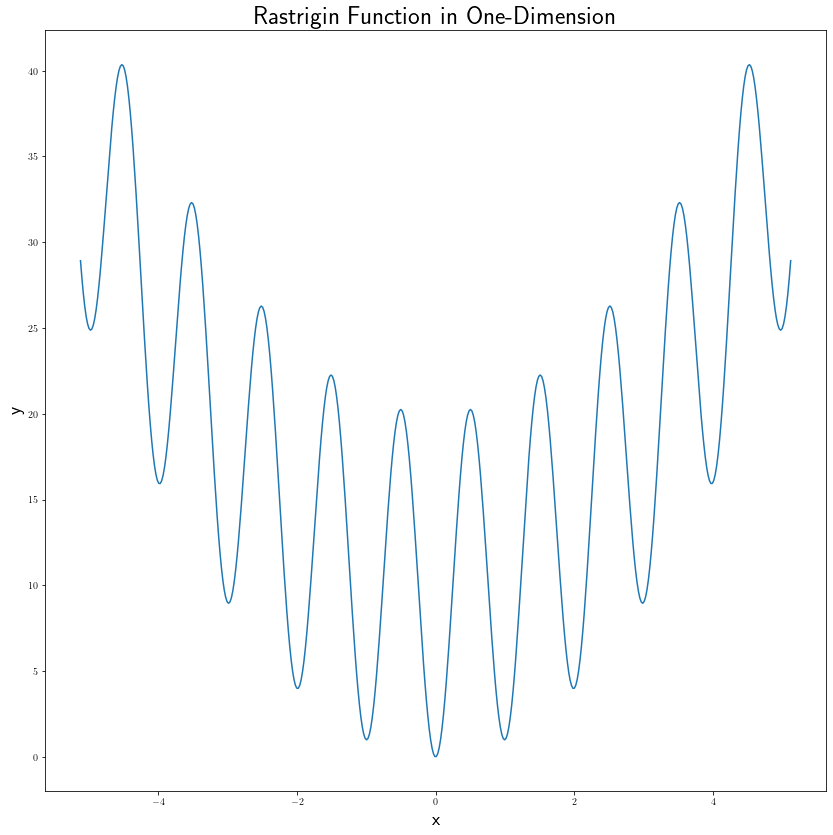

In [2]:
int_len = 500

rastrigin = pg.problem(pg.rastrigin(dim = 1))
arr_x = np.linspace(-5.12, 5.12, num = int_len)

# Pygmo doesn't allow evaluation of an array. Use for loop.
arr_y = np.empty(int_len)
for i, x in enumerate(arr_x):
    arr_y[i] = rastrigin.fitness([x])
    
fig, ax = plt.subplots(figsize = (14, 14))
ax.plot(arr_x, arr_y)
ax.set_xlabel("x", fontsize = 19)
ax.set_ylabel("y", fontsize = 19)
ax.set_title("Rastrigin Function in One-Dimension", fontsize = 25)

### Types of Algorithms <a class = "anchor" id = "types"></a>

To circumvent getting stuck in a local minimum algorithms should be able to climb out of it. An obvious approach would be starting from many different points and choosing the best solution. Such a random search can be improved by using it as a starting point for local optimization, i.e. application of gradient decent or Newton-Method ([Kenneth L. Judd](#Judd1998)) and then choosing the best vector. 

The umbrella term for these types of algorithms is stochastic search. This brings us to the general approach provided by the `pygmo` library ([Biscani and Izzo (2020)](#Biscani2020)). At the beginning of an optimization exercise a set of random points is generated a so called population, and its function value or fitness is evaluated. From here algorithms perform different operations to spawn a new set of points which is called a generation. This processs continues until a preset bound of generations is achieved or the change in function value respectively input has changed only marginally during the last $ g $ generations. More formally if at generation $ k $
$$ \left| \max_{x \in X_l} f(x) - \max_{x \in X_m} f(x) \right| < \delta  \text{ for }l, m = k - g, ..., k - 1, k$$
and 
$$ \left| \arg \max_{x \in X_l} f(x) - \arg \max_{x \in X_m} f(x) \right| < \delta  \text{ for }l, m = k - g
, ..., k - 1, k$$
where $ X_l $ represents the set of points or so called individuals in generation $ l $.

### Algorithms <a class = "anchor" id = "algos"></a>

I considered in total eight different algorithms. Namely, Artificial Bee Colony (*ABC*) by [Dervis Karaboga and Bahriye Basturk (2007)](#Karaboga2007), Covariance Matrix Adaption Evoluation Strategy (*CMAES*) by [Nikolaus Hansen (2006)](#Hansen2006), Differential Evolution (*DE*) by [Rainer Storn and Kenneth Price (1997)](#Storn1997), Self-Adaptive Differential Evolution (*SADE*) by [Saber M. Elsayed, Ruhul A. Sarker, Daryl L. Essam (2011)](#Elsayed2011), Monotonic Basin Hopping (*MBH*) by [David J. Wales, Jonathan P. K. Doye](#Wales1997), Particle Swarm Optimization (*PSO*) by [Riccardo Poli, James Kennedy and Tim Blackwell (2007)](#Poli2007), Generational Particle Swarm Optimization (*PSO GEN*) by [Biscani and Izzo (2020)](#Biscani2020) and Simple Evolutionary Algorithm (*SEA*) ([Pietro S. Olivet, Jun He and Xin Yao (2007)](#Oliveto2007)). I will refer to these algorithms by the abbreviations written in parentheses. Except for *MBH* all algorithms are derivative free and use only function values themselves to generate a solution. Note, that *PSO* and *PSO GEN* differ only marginally. Results might then be very similar.

For reference I also implemented a so called naive algorithm as proposed by [Judd (1998)](#Judd1998). Similar as before a set of initial points is generated. From the starting point with the worst function value is selected and local optimization is performed. The formerly worst point is then replaced by the new solution. This process continues until a tolerance value in change in x value is no longer satisfied. If a gradient is present the algorithm uses *LBFGS* and if not it uses the *Nelder-Mead* method ([Judd (1998)](#Judd1998)).

Most of the algorithms listed above are so called metaheuristics. Many of them lend their behavior from natural systems. Metaheuristics themselves remain a topic of hot debate as theoretical foundations are largely missing and accusations of overconscientious use of nature inspired metaphors. Consider [Kenneth Sörensen (2012)](#Sörensen) as an example. Still metaheuristics are a powerful tool for problem solving, in our example global optimization. The advantage of such algorithms is that in general few assumptions are needed for application and large search spaces can be evaluated ([Dongshu Wang, Dapei Tan, Lei Liu (2017)](#Wang2017)). In example most algorithms of the `pygmo` library don't even need a gradient. However, convergence can not be guaranteed. It is therefore necessary to run experiments to validate the usefulness of such algorithms.

I will not explain every single algorithm in detail but shed some light on the most important steps undertaken. As an example consider *DE* by [Storn and Price (1997)](#Storn1997), which is one of the simplest metaheuristics. It makes use of concepts as mutation, crossover and selection. Starting with some assignments, $ x_{i, g} $ is the decision vector of individual $ i $ in generation $ g $. The vector $ x_{i, g} $ is of dimension $ D $ and has entries $ x_{ij, g} \text{ for } j = 1, ... D $.
1. Initialize a population of $ N $ individuals that cover the entire search space. Meaning, draw $ x_{i, 1} $ for $ i = 1, ..., N $.
2. Generate for each $ x_{i, g} $ a mutant vector according to $ v_{i, g + 1} = x_{r_1, g} + F \cdot (x_{r_2, j} - x_{r_3, g}) $ for indexes $ r_1, r_2, r_3 = 1, ..., N $ which are unique, and $ F \in [0, 2] $.
3. Form a new decision vector $$ u_{ij, g + 1} = \begin{cases} 
v_{ij, g + 1} \qquad \; \text{ if } randb(j) \leq CR \text{ or } j = rnbr(r) \\ 
x_{ij, g} \qquad \quad \text{ if } randb(j) > CR \text{ and } j \neq rnbr(i) 
\end{cases} $$ for $ j = 1, 2, ..., D $. $ randb(j) $ is the $ j $th evaluation fo a uniform random number generator on $ [0, 1] $. $ CR \in [0, 1] $ is the crossover constant. $ rnbr(i) $ is a randomly chosen index which guarantees that at least one parameter in the next generation is from $ v_{i, g + 1} $.

Although, algorithms differ dramatically most rely on steps similar to the ones described above. By starting from many different points we intend to cover the whole domain. Mutation and crossover are used to modify existing points and allow for diversity of solutions. Preventing premature convergence. As a last step selection determines whether the newly generated points should be accepted as the next generation i.e. improved our solution.

### Test-Problems <a class = "anchor" id = "problems"></a>
Test problems are functions used to assess the performance of an algorithm. Be it optimization or another topic where numeric approaches are used. The area of global optimization knows a whole range of such functions. A good reference for unconstrained optimization is provided by [Momin Jamil and Xin-She Yang (2013)](#Jamil2013). Such a function should be in general hard to solve. [Jamil and Yang (2013)](#Jamil2013) list the following properties. Multimodality, a test function should have many local minima. This tests the ability of an algorithm to escape from local minima. Flat surfaces, a function with flat surfaces gives only little information to an algorithm in which direction an improvement of the function value is possible. Scaling, the dimensionality of the decision vector of a function. Testing, an algorithm's ability to cope with high dimensions.

For illustration purposes of multimodality and flat surfaces I present two of the most common test functions. The Rosenbrock function proposed by [Howard H. Rosenbrock (1960)](#Rosenbrock1960) and the Ackley function by [David Ackley (1987)](#Ackley1987). Dimensionality can not be presented since I can display at most two input dimensions.

#### Rosenbrock <a class = "anchor" id = "rosenbrock"></a>
The Rosenbrock function is defined as 
$$ f(x) = \sum_{i = 1}^{D - 1} [100 (x_{i + 1} - x_i^2)^2 + (x_i - 1)^2] $$
where $ D $ is the number of dimensions. The global minimum is located at $ x^* = (1, ..., 1)$. [Figure 1](#Fig_rosenbrock) shows a surface and a contour plot of the two dimensional Rosenbrock function. The red cross marks the global minimum. As can be seen the function is unimodal and has a very flat surface surrounding the global minimum. Optimizers could then get lost in the valley.
![Surface- and Contour-Plot of Rosenbrock Function](Plots/Test_Functions/Rosenbrock.png) <a class = "anchor" id = "Fig_rosenbrock"></a>

#### Ackley <a class = "anchor" id = "ackley"></a>
The second example is the so called Ackley function which can be seen in two dimensions in [Figure 2](#Fig_ackley). The function has many local minima, where an algorithm might get stuck. This function tests specifically how a solver trade-offs short term gains against long term gain. The function is defined as
$$ f(x) = -20 \exp(-0.02 \sqrt{D^{-1} \sum_{i = 1}^D x_i^2} - \exp(D^{-1} \sum_{i = 1}^D \cos(2 \pi x_i)) + 20 + e $$
where $ D $ is again the number of dimensions and $ e = \exp(1) $. The global minimum is in $ x^* = (0, ..., 0) $.
![Surface- and Contour-Plot of Ackley Function](Plots/Test_Functions/Ackley.png) <a class = "anchor" id = "Fig_ackley"></a>

#### Functions under Consideration <a class = "anchor" id = "all_functions"></a>
In total I use 20 test functions in my project. Namely Rosenbrock, Rastrigin, Schwefel, Ackley, Griewank,       Beale, Goldstein-Price, Booth, Bukin N.6, Matyas, Lévi N.13, Himmelblau, Three-Hump Camel, Cross in Tray, Egg Holder, Holder Table, McCormick, Schaffer N.2, Schaffer N.4 and Styblinski Tang which can be found in [Momin and Yang](#Jamil2013).

### Benchmarking approach <a class = "anchor" id = "bmk"></a>

To get a complete picture of the performance of the aforementioned [algorithms](#algos) some points have to be considered beforehand. First, chance is one of the central components. Therefore, a solution might change depending on the initial starting points. It is therefore important to run each experiment several times to get unbiased results ([Beiranvand et al. (2017)](#Beiranvand2017)). I set the number of iterations $ i $ for every algorithm on a problem equal to $ \mathcal{I} = 5 $. Second, the population size is a tuning factor common to all algorithms and possibly influences the convergence properties of an algorithm. I considered different population sizes, namely $ \mathcal{PS} = \{20, 50, 100, 200\} $. I didn't perform parameter tuning since this would be beyond the scope of this project. This might give algorithms which perform some kind of parameter tuning an edge i.e. *SADE*. Performance is compared in the [results](#results) section.

As mentioned above global optimization is especially challenging for non-convex problems. Therefore, the test functions under consideration were mainly non-convex with many local minima and/or flat valleys. I considered only single-objective optimization with box-constraints. All problems under consideration have a known global minimum, which is necessary for computing various measures of accuracy and performance.

As mentioned in the [Abstract](#abst) my benchmarking approach follows the guide by [Beiranvand et al. (2017)](#Beiranvand2017). I present statistics and graphics to evaluate for every algorithm the *efficency* measured as number of function evaluations, *reliability* measured by the probability of success and the *quality* of the solution through different accuracy metrics.

#### Metrics <a class = "anchor" id = "metrics"></a>

The metrics considered are the distance between the best solution found by an optimizer $ \bar{x} $ and the global optimum $ x^*$.
$$ f_{acc} = f(\bar{x}) - f(x^*) \text{, and } x_{acc} = \| \bar{x} - x^* \| .$$
Since the codomain of the test functions can differ it is useful to normalize the accuracy measure.
$$ f_{acc}^n = \frac{f(\bar{x}) - f(x^*)}{f(x^0) - f(x^*)} \text{, and } x_{acc}^n = \frac{\|\bar{x} - x^* \|}{\|x^0 - x^* \|} .$$
Where $ x^0 $ is the starting vector. Since I have multiple starting values I choose $ x^0 $ to be the starting vector for which the function value is minimal. At last I calculate $ \log_10 $ of $ f_{acc}^n $ and $ x_{acc}^n $. Multiplied by $ -1 $ it can be interpreted as the number of digits of accuracy obtained. This gives us the tools to estimate the quality of an algorithm. 

To get a sense of the reliability of an optimizer I calculated for every algorithm the probability of finding the true optimum. I set a tolerance for convergence in function value of $ \frac{1}{1,000,000} $ and of $ \frac{1}{10,000} $ for convergence in x-value.

Additionally I use a rating proposed by [Stephen C. Billups, Steven P. Dirkse and Michael C. Ferris (1997)](#Billups1997). They classify an algorithm as *competitive* if it holds that $ T_A \leq 2 T_{min} $ for algorithm $ A $, where $ T $ is the solving time of an optimizer and $ T_{min} $ the best solving time in a benchmarking exercise. An algorithm is then *very competitive* if $ T_A \leq \frac{4}{3} T_{min} $. I used function evaluations as a measure of solving time.

#### Graphics <a class = "anchor" id = "graphics"></a>

Graphics are an indespensable tool allowing us to assess the performance, reliability and quality of an algorithm at the same time. Since some of the grpahics are hard to interpret, I supply some illustration for a small example benchmarking exercise I did beforehand. Explanations are thus limited to an absolute minimum. It compares *CMAES* and *SADE* on the test functions *Himmelblau*, *Rastrigin*, *Rosenbrock* and *Schwefel*. All plots are segregated by population size. A detailed discussion of results can be found in the [results](#results) section.

#### Convergence Plots <a class = "anchor" id = "conv_plot"></a>

An intuitive tool for such an analysis is a convergence plot as seen in [Figure 3](#Fig_conv_plot) for the Rastrigin function ([Jamil and Yang (2013)](#Jamil2013)) comparing *CMAES* and *SADE*. It plots the best function value achieved by an algorithm against a computational budget $ k $. 

In case of [Figure 3](#Fig_conv_plot) computational budget is given by the number of function evaluations. Since I started multiple runs ($ \mathcal{I} = 100 $) for a given specification of algorithm, problem and population size I have to aggregate the best function value for a given budget. A natural metric would be the mean. However, since the mean is sensitive to outliers a single divergent iteration could devaluate an otherwise good algorithm. Therefore, I plotted the median for each level of function evaluations. Note, that the convergence plot increases for CMAES for a population size of $ ps = 100 $ after $ k = 5000 $ function evaluations. This is due to the fact, that convergent algorithm runs stopped already, leaving many divergent algorithm runs, pushing the median back up. A convergence plot gives us direct insight about the performance of an algorithm, however, it can only present a single problem at a time and by aggregating across iterations some information might get lost. For this reason I will rarely use convergence plots.

![Convergence Plot Rastrigin Function](Plots/Convergence_Plot/convergence_plot_test.png) <a class = "anchor" id = "Fig_conv_plot"></a>

#### Performance Profiles <a class = "anchor" id = "perf_profile"></a>

The performance profile is the first tool for assessing efficency and reliability of an optimizer across different problems at the same time. For a given set of problems $ \mathcal{P} $, algorithms $ \mathcal{A} $ and a convergence test $ \mathcal{T} $. There is a performance measure $ t_{p, a, i} > 0 $, where $ p,\, a, \, i $ are indices for a given problem, algorithm and iteration $ (p, a, i) \in \mathcal{P} \times \mathcal{A} \times \mathcal{I} $. In case of this project, the performance measure $ t $ is the sum of function, gradient and hessian evaluations. The value $ r_{p, a, i} $ is defined as:

$$ r_{p, a, i} = \begin{cases} 
\frac{t_{p, a, i}}{\min\{t_{p, a, i}: \, (a, i) \in \mathcal{A} \times \mathcal{I} \}} \quad \text{if convergence is passed} \\
\infty \qquad \qquad \qquad \text{ if convergence fails}
\end{cases} $$

The best performing optimizer will have $ r_{p, a, i} = 1 $. For a specific problem $ p $ and cutoff $ \tau > 1 $, the performance profile for solver $ a $ is defined as follows:

$$ \rho_a(\tau) = \frac{1}{|\mathcal{P}| |\mathcal{I}|} \text{size} \{p \in \mathcal{P}: \, r_{p, a} \leq \tau \} $$

where $ |\mathcal{P} | $ and $ |\mathcal{I} | $ denotes the cardinality of the set $ \mathcal{P} $ respectively $ \mathcal{I} $ the number of iterations performed for a single algorithm on a problem. I had to adapt the part for the iterations. $ \rho_a(1) $ represents the fraction for which solver $ a $ is the best performing solver. For a given level of $ \tau $ we get the fraction of times in which algorithm $ a $ is within a factor of $ \tau $ of the best solution.

Some final words of caution on performance profiles are necessary. First, a performance profile only compares a solution relative to the best solution. It is not guaranteed that the best solution is also the global optimum. Second, the shape of a performance profiles is dependent on the algorithms under consideration. Consider as an example, excluding the best performing algorithm from a performance profile. The formerly second best performing optimizer is now the best and so the values of $ r_{p, a, i} $ will change for the whole set. Third, the performance profile depends on the metric chosen by the researcher and might be subject to change.

![Performance Profile](Plots/Performance_Profiles/performance_profile_test.png) <a class = "anchor" id = "Fig_perf_profile"></a>

[Figure 4](#Fig_perf_profile) compares again *SADE* to *CMAES* on the above mentioned problems. We can clearly see that *SADE* dominates *CMAES* for all $ ps \in \mathcal{P} $. Consider the profile for $ ps = 20 $. For a value of $ \tau = 20 $ we see that $ 25\% $ of the solutions computed by *SADE* are within that factor, so among the best. For *CMAES* the value is only roughly $ 5\% $.

#### Accuracy Profiles <a class = "anchor" id = "acc_profile"></a>

Accuracy profiles are able to visualize an entire benchmarking test set. But are only applicable for problems with a known solution. For every $ a \in \mathcal{A} $ and $ p \in \mathcal{P} $, we calculate an accuracy measure, where $ M $ is the maximum improvement value under consideration.

$$ \gamma_{p, a, i} = \begin{cases}
-f_{acc}^{p, a, i}, \quad \text{if } -f_{acc}^{p, a, i} \leq M \\
M, \quad -f_{acc}^{p, a, i} > M \text{ or } f_{acc}^{p, a, i} \text{ is undefined}
\end{cases} $$

where $ f_{acc}^{p, a, i} = \log_{10}(f(\bar{x}_{p, a, i} - f(x_p^*)) - \log_{10}(f(x_p^0) - f(x_p^*)) $, $ x_{p, a, i} $ is the candidate solution, obtained by solver $ a $ for problem $ p $ in iteration $ i $, $ x_p^* $ is the optimal solution for problem $ p $, and $ x_p^0 $ is the initial point for problem $ p $. To measure the performance we calculate 

$$ R_a (\tau) = \frac{1}{|\mathcal{P}| |\mathcal{I}|} \text{size} \{ \gamma_{p, a, i} | \gamma_{p, a, i} \geq \tau, \, p \in \mathcal{P} \} $$

it shows the proportion of problems for which the algorithm $ a $ achieves an accuracy of at least $ \tau $. Remember that the accuracy measure used here, can be roughly interpreted as the number of digits obtained. $M $ is then the considered digits of accuracy. This makes accuracy profiles really useful since it allows us to judge, how close an algorithm gets to the optimum.

Consider as an exmaple [Figure 5](#Fig_acc_profile) which shows a function value based accuracy profile. We see again that *SADE* dominates *CMAES* for all $ ps \in \mathcal{PS} $. *SADE* achieves in nearly all cases an accuracy of at least $ 5 $ digits. Interestingly, as $ \tau $ increases the percentage of solutions found achieving at least that accuracy decreases and the data profiles for both algorithms decrease.

![Accuracy Profile](Plots/Accuracy_Profiles/accuracy_profile_test.png) <a class = "anchor" id = "Fig_acc_profile"></a>

#### Data Profiles <a class = "anchor" id = "data_profile"></a>

Data profiles were originally proposed for derivative-free optimization algorithms ([Beiranvand et al. (2017)](#Beiranvand2017)). They show, which percentage of problems for a given value of $ \tau $ can be solved within the budget of $ k $ function evaluations. Since it is assumed, that the number of functions evluations grows with the dimension of the problem $ n_p $, it is defined as

$$ d_a (k) = \frac{1}{|\mathcal{P}| |\mathcal{I}|} \text{size} \{p \in \mathcal{P}: \, \frac{t_{p, a, i}}{n_p + 1} \leq k \}$$

here, $ t_{p, a, i} $ is the number of function evaluations required to satisfy the convergence test, $ d_a (k) $ is the fraction of problems $ p $ solved by $ a, i $ within $ k $ evaluations. Data profiles are independent of other solvers. To compare gradient-free and gradient-based methods I also implemented a data profile that accounts first sums the number of function, gradient and hessian evaluations. Again data profiles can be computed for x-values or for function values. A big advantage of data profiles is that they don't depend on the choice optimizers as [performance profiles](#perf_profile).

![Data Profile](Plots/Data_Profiles/data_profile_test.png) <a class = "anchor" id = "Fig_data_profile"></a>

From [Figure 6] we see that *SADE* reaches convergence for all $ ps $ farely fast, while *CMAES* stalls after some generations. Interestingly, convergence improves for *CMAES* with growing population size.

### Application of the Benchmark Class <a class = "anchor" id = "app_bmk"></a>

To realize this benchmarking exercise I programmed a `benchmark` class which allows the definition of a benchmarking task, i.e. problems considered, algorithms tested and further parameters set. Note, that all methods are documented. Still I will give a walkthrough on the setup of this project.

I define a list of problems and algorithms, which will be passed to the created instance. Settings for individual problems or algorithms can be supplied through keyword arguments. I set the keyword arguments to `None` for test functions which are allow only two dimensional inputs. On the algorithm side I kept the default settings except for *MBH* which works with local optimizers in every generation. Due to computational cost I set the local optimizer to *LBFGS*. If no gradient is supplied by the problem class from the `pygmo` library the algorithm falls back to using the *Nelder-Mead* algorithm.

`dict_labels` supplies legend labels for the plots I generate in the [results](#results) section.

In [5]:
list_problem_names = (
    [
        "rosenbrock", "rastrigin", "schwefel", "ackley", "griewank", 
        "beale", "goldstein_price", "booth", "bukin_n6", "matyas",
        "levi_n13", "himmelblau", "camel", "cross_in_tray",
        "eggholder", "h_table", "mccormick", "schaffer_n2", "schaffer_n4",
        "styblinski_tang"
    ]
)

list_algorithm_names = [
    "bee_colony", "de", "sea", "sade", "cmaes", "pso", "pso_gen", "mbh", "naive"
]

# UDP have mostly two dimensions
kwargs_problem = {
    "rosenbrock": {"dim": 5}, "rastrigin": {"dim": 10}, "schwefel": {"dim": 2}, 
    "ackley": {"dim": 4}, "griewank": {"dim": 6}, "beale": None, "goldstein_price": None,
    "booth": None, "bukin_n6": None, "matyas": None, "levi_n13": None, "himmelblau": None,
    "camel": None, "cross_in_tray": None, "eggholder": None, 
    "h_table": None, "mccormick": None, "schaffer_n2": None, "schaffer_n4": None,
    "styblinski_tang": {"dim": 8}
}

kwargs_algorithm = {
    "bee_colony": None, "de": None, "sea": None, "sade": None, "cmaes": None, "pso": None, 
    "pso_gen": None, "mbh": {"algo": pg.nlopt("lbfgs")}, "naive": None
}

dict_labels = {
    "bee_colony": "Bee Colony", "de": "DE", "sea": "SEA", "sade": "SADE", 
    "cmaes": "CMAES", "pso": "PSO", "pso_gen": "gen. PSO", "mbh": "MBH",
    "naive": None
}

bmk_project = benchmark(
    list_problem_names,
    list_algorithm_names,
    kwargs_problem,
    kwargs_algorithm
)

For every algorithm on every problem I set iterations equal to $ \mathcal{I} = 20 $, the maximum number of generations allowed to $ 500 $, the tolerance for convergence in function value to $ \frac{1}{1,000,000} $ and for convergence in x-value to $ \frac{1}{10,000} $. An algorithm is then flagged as convergent in f if $ f_{acc} \leq \frac{1}{1,000,000} $ respectively  in x if $ x_{acc} \leq \frac{1}{10,000} $ as defined in the [metrics](#metrics) section. To guarantee reproducability I set a seed. The verbosity denotes the interval in which generation a log entry is created by an algorithm. Since I want a detailed dataset I set `verbosity` to $ 1 $.

In [6]:
bmk_project.gen = 500
bmk_project.iterations = 20
bmk_project.f_tol = 1e-06
bmk_project.x_tol = 1e-04
bmk_project.verbosity = 1
# Setting a seed that is totally uncorrelated to my personal life!
bmk_project.seed = 2093111

Running the experiment produces two types of results. First, an accuracy `pandas` dataframe and second a logs dataframe. Since the computational cost of the exercise is fairly high I store the log and accuracy dataframes as csv-files.

The accuracy instance holds a dataframe containing accuracy measures described in the [metrics](#metrics) section, algorithm, iteration, number of function, gradient and hessian evaluations, problem and population size. It is only generated once at the end of an optimization run.

The logs instance holds a log entry for every generation. Say, a population of an algorithm evolved for $ 40 $ generations we would have $ 40 $ rows for that algorithm on a given problem run. The logs file contains information about the current generation, function evaluations, the best function value found by an algorithm during the current run and information about iteration, algorithm, problem and population size. Further accuracy measures are computed.

To actually run the exercise I use the method `run_experiment()` which runs $ \mathcal{I} = 5 $ iterations for every $ a \in \mathcal{A}$ and population size $ ps \in \mathcal{PS} $ on $ p \in \mathcal{P} $.

Note that the `RuntimeWarning` thrown from time to time is caused by an algorithm finding a solution so close to the global optimum that $ \log_{10} $ is essentially evaluated at $ 0 $. The accuracy in number of digits is then set to infinity.

In [ ]:
bmk_project.run_experiment()
bmk_project.accuracy.to_csv("../Data/Accuracy_Final.csv")
bmk_project.logs.to_csv("../Data/Logs_Final.csv")

### Results <a class = "anchor" id = "results"></a>

To get the most complete picture I supply accuracy measures for function value and input value.

#### Descriptive Statistics <a class = "anchor" id = "res_desc"></a>

As a first step I compute the accuracy metrics and the competitiveness classification of all algorithms by running the method `get_descriptives`.

In [8]:
bmk_project.get_descriptives()

C:\Users\Wilms\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


Since the table of descriptives is quite extensive I will display only the results for algorithms aggregated across problem and population size. The full table can be found in the [appendix](#appendix). What is striking, is that 

Picking absolut accuracy for both function value and x value i.e. $ f_{acc}^{n}, \, x_{acc}^n $ we can see that the mean accuracy is always higher (worse) than the median accuracy. This is due to the means sensitivity to (upward) outliers. Comparing the median between algorithms I find that *MBH*, *DE*, *SADE*, *PSO* and *PSO GEN* achieve the highest accuracy in function value, in that order. This holds true for accuracy of x-value. Indicating high quality for these optimizers. *SADE*, *PSO* and *PSO GEN* show also high reliability. It is striking that *SEA* didn't converge once.

In [45]:
df_acc = bmk_project.accuracy
list_metrics = [utils.q25, "median", "mean", utils.q75]
desc_all = (df_acc.
            groupby("algorithm").
            aggregate(
                {"acc_abs_f": list_metrics, 
                 "acc_abs_x": list_metrics, 
                 "converged_f": "mean", 
                 "converged_x": "mean"}
            )
           )

desc_all.columns = desc_all.columns
desc_all.index = desc_all.index.str.upper()
desc_all.index = desc_all.index.str.replace("_", " ")

display(
    HTML(
        desc_all.to_html()
    )
)

#### Competetiveness <a class = "anchor" id = "res_compet"></a>

Competitiveness as proposed by [Billups et al. (1997)](#Billups1997) is presented in the table below. Interestingly, only the naive algorithm is considered as very competitive. For reference, I included the fraction of times the algorithm actually converged. This points out the statistics flaws. Although the naive algorithm is deemed very competitive it is not very reliable and ranks second to last before the *SEA* algorithm. Still the results are interesting showing that the naive approach outclasses metaheuristics in terms of computational cost. The next closest, "real", competitor *CMAES* is within a factor of $ 200 $.

Overall the highest rate of convergence is achieved by *SADE* followed by *PSO* and *PSO GEN*. *DE* achieves also high reliability in function value but not in x value. *SEA* didn't converge once and is therefore not listed here.

In [10]:
display(
    HTML(
        bmk_project.competition.to_html()
    )
)

,Evaluations,Competitiveness,Convergence in f-value in %,Convergence in x-value in %
Algorithm,,,,
BEE_COLONY,128952.352941,Not competitive,53.1250,45.3125
CMAES,4268.994413,Not competitive,54.3750,36.2500
DE,17463.106383,Not competitive,73.4375,46.5625
MBH,5570.141243,Not competitive,55.3125,55.0000
NAIVE,222.110345,Very competitive,45.3125,45.3125
PSO,53183.076923,Not competitive,69.0625,67.5000
PSO_GEN,53777.064220,Not competitive,68.1250,65.3125
SADE,18236.000000,Not competitive,78.1250,65.9375


#### Graphics <a class = "anchor" id = "res_graphs"></a>

Since benchmarking profits immensly from the use of plots I discuss resulting performance, accuracy and data profiles in detail. All plots were produced considering convergence in function value and in x value to ensure that both sides are presented. This way I hope to find which algorithms might be better in finding the optimal vector x.

#### Performance Profiles <a class = "anchor" id = "res_perf_profile"></a>

The performance profiles show an interesting picture. The naive approach is very fast but stalls quickly. All algorithms show a steady increase in $ \tau $. This leads to *SADE*, *DE*, *CMAES* surpassing the naive method. Eventually *PSO*, *PSO GEN* and *MBH* surpass the naive method as well. Interestingly relative performance of *PSO* decreases for growing $ ps $. *SEA* isn't displayed as it didn't achieve convergence in the displayed amount of function evaluations.

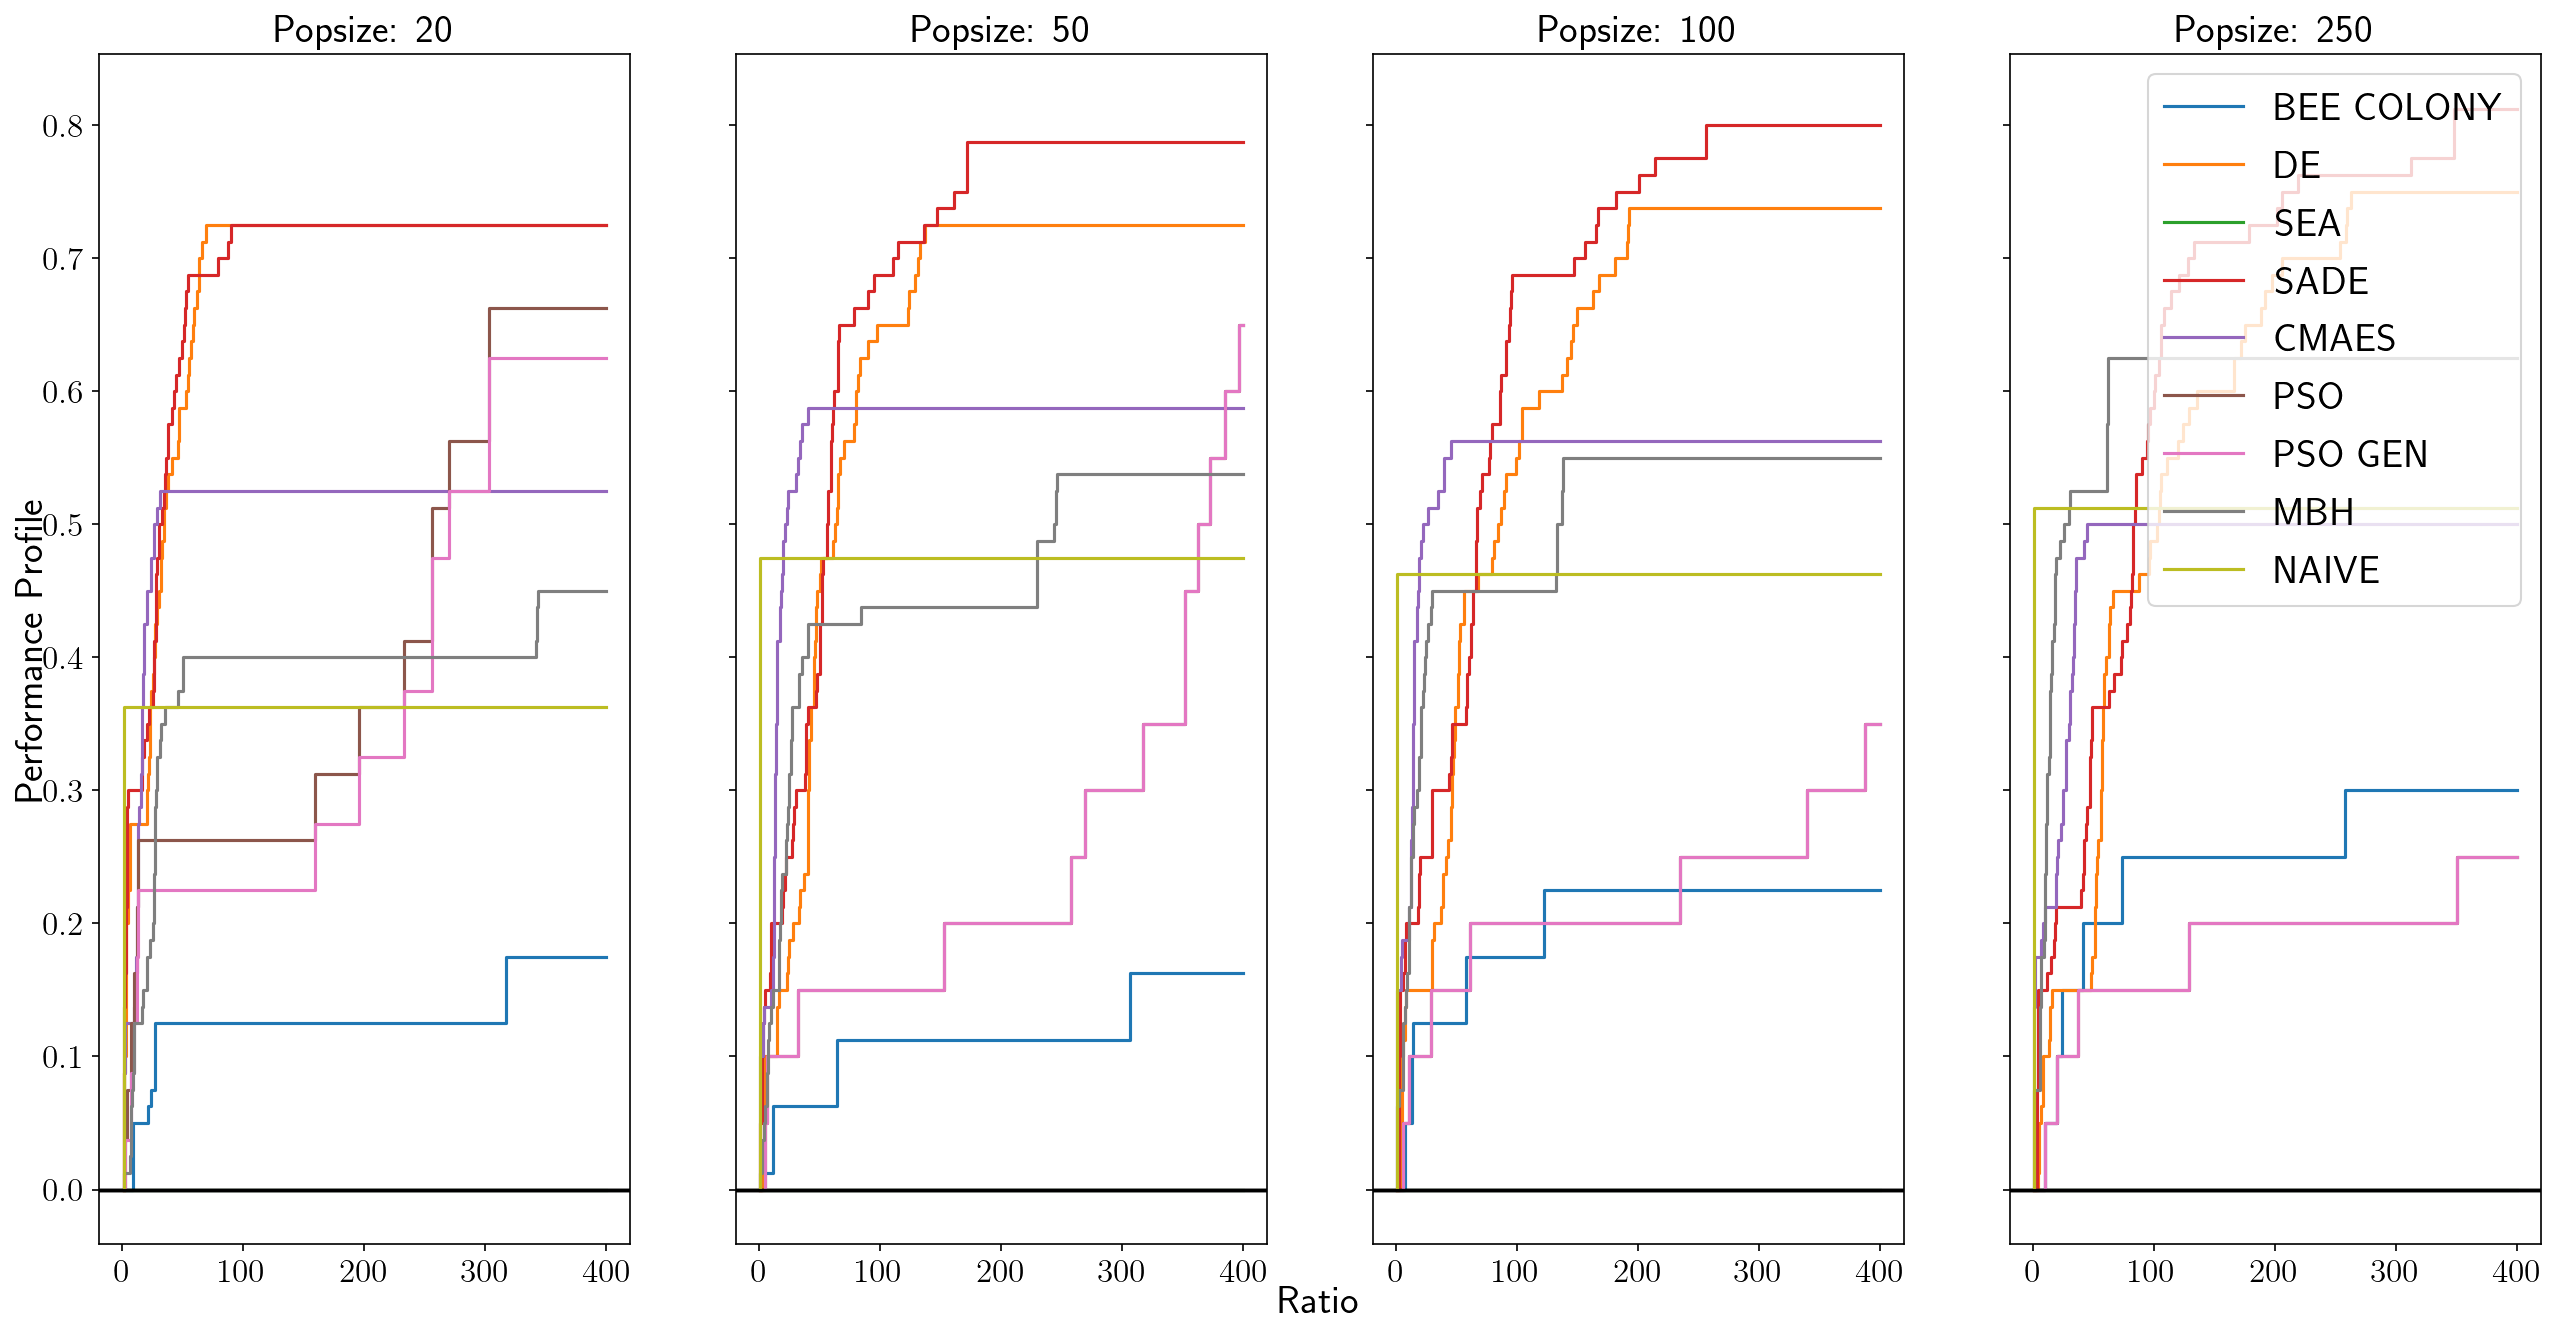

In [20]:
fig_perf_profile_f = bmk_project.performance_profile(
    range_tau = 400,
    subplot_kwargs = {"alpha": 0.25}
)
fig_perf_profile_f.savefig("../Plots/Performance_Profiles/Performance_Profile_Final.png", dpi = 200)

The performance profile considering x values is different in the way that for $ ps = 20, 50 $ *PSO* and *PSO GEN* perform better after a certain level of function evaluations. The distance between *DE* and *SADE* widens here.

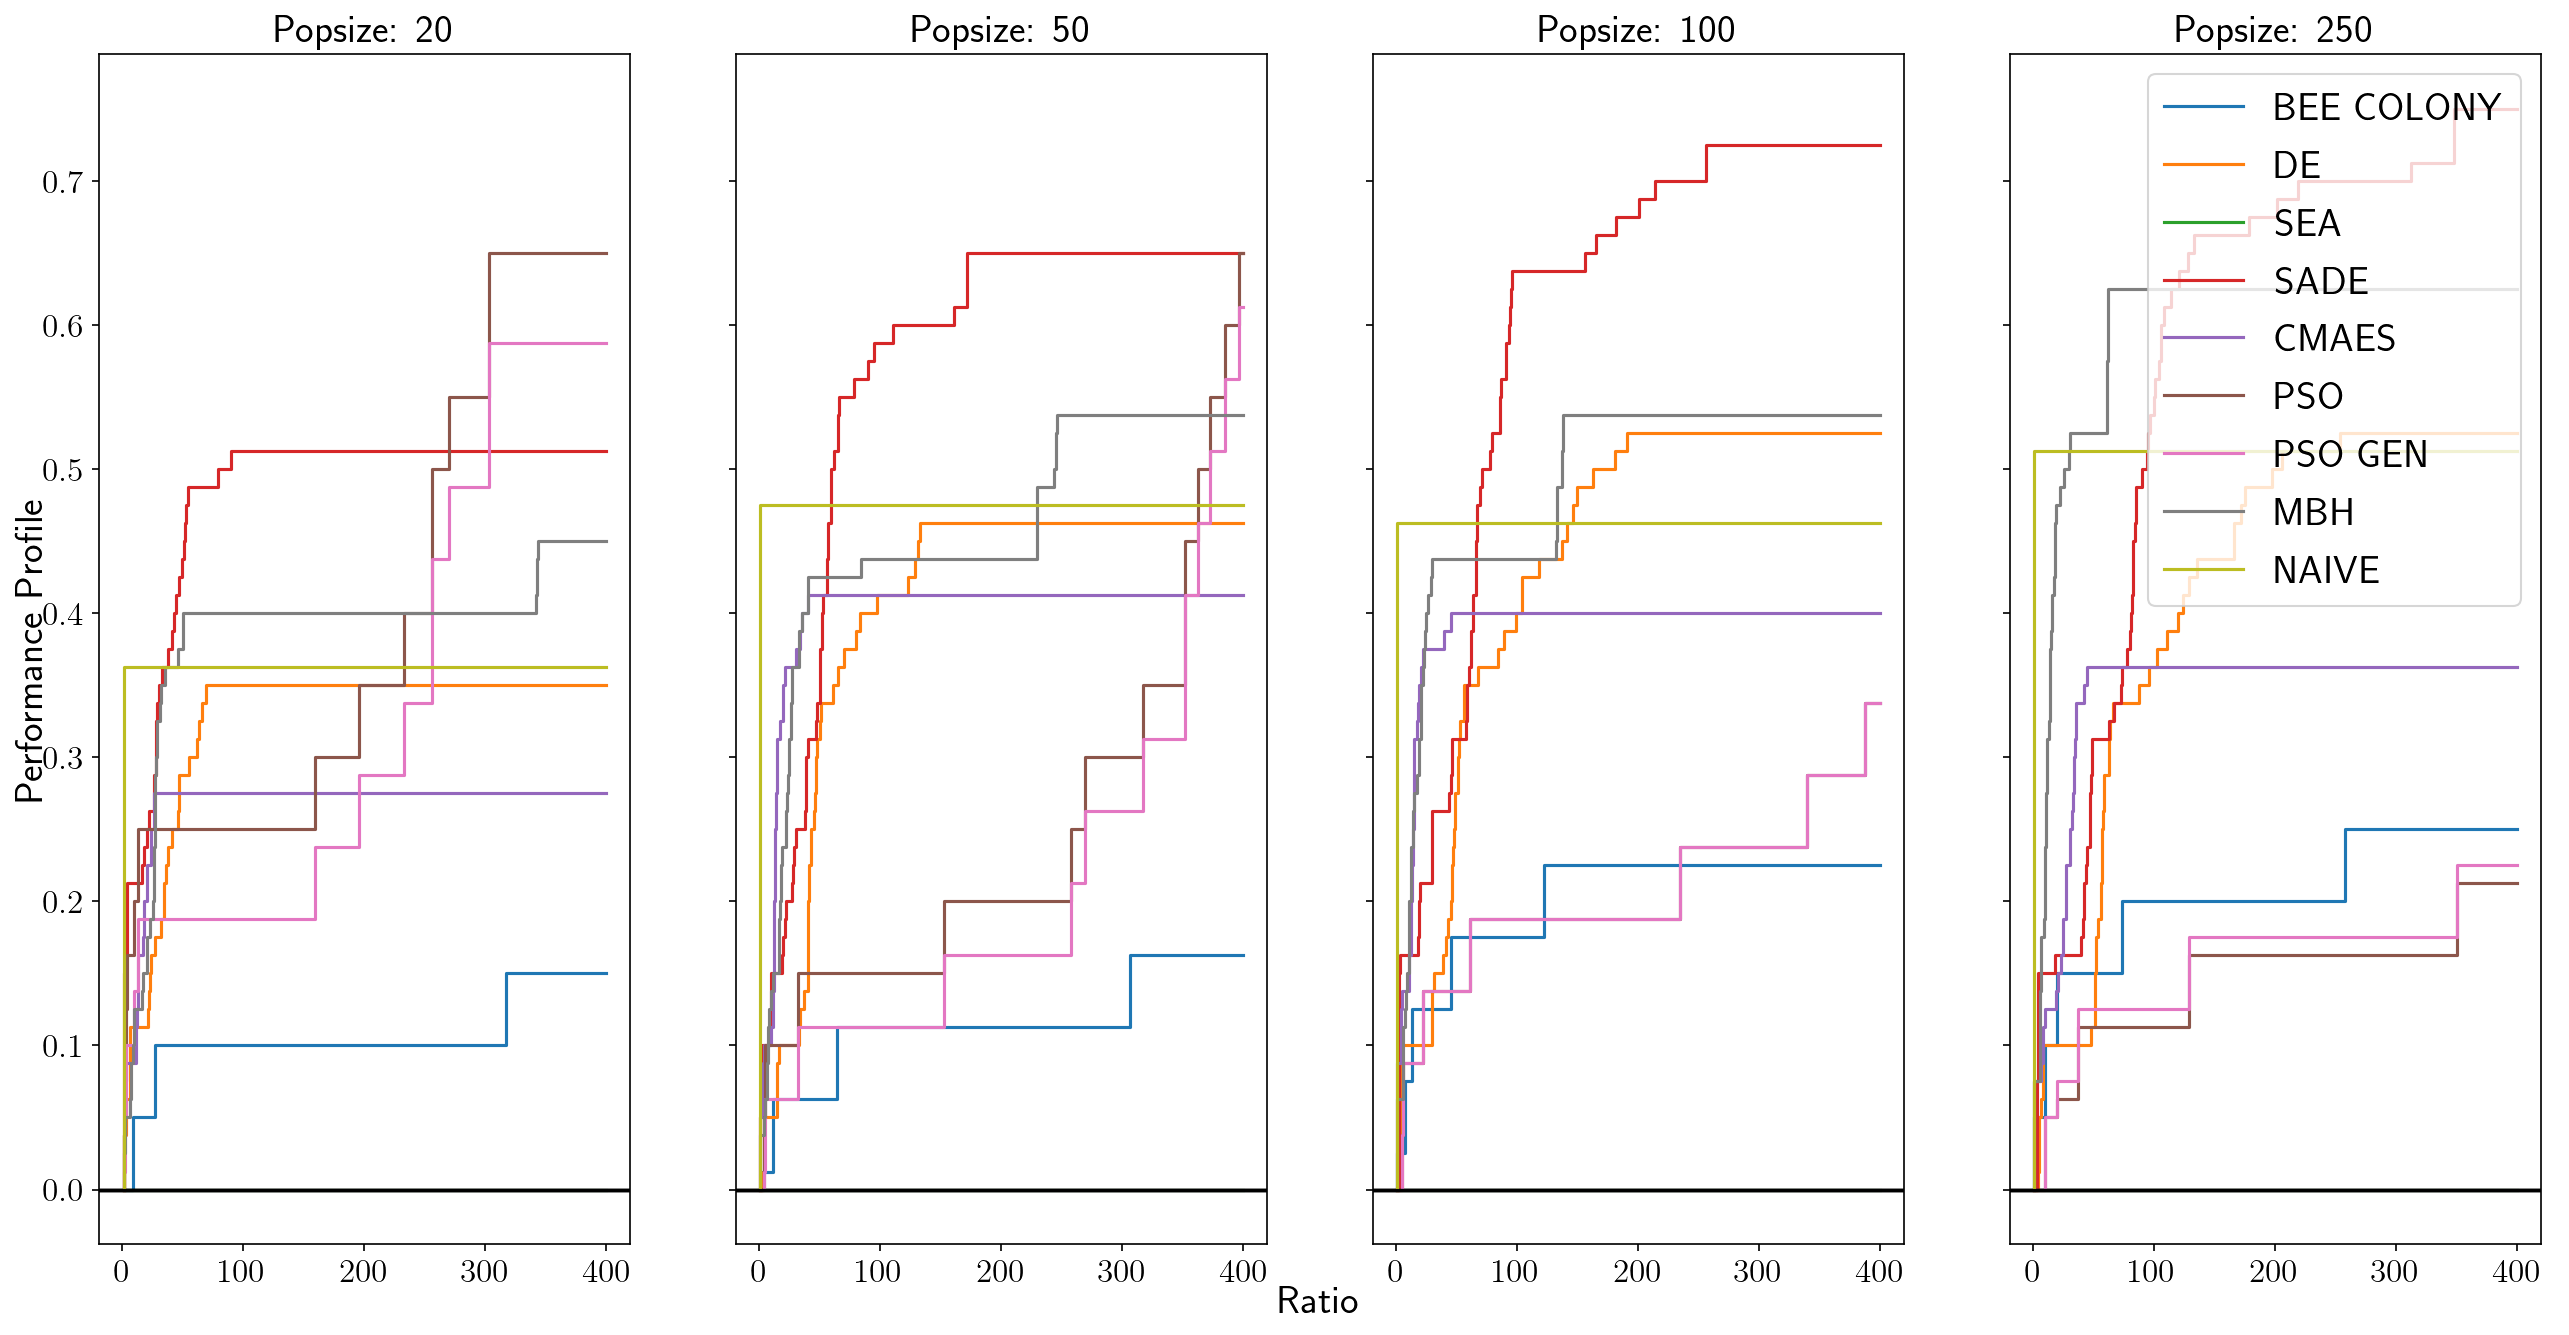

In [19]:
fig_perf_profile_x = bmk_project.performance_profile(
    range_tau = 400,
    conv_measure = "x_value", 
    subplot_kwargs = {"alpha": 0.25}
)
fig_perf_profile_x.savefig("../Plots/Performance_Profiles/Performance_Profile_Final.png", dpi = 200)

The look on the data profiles showed us that some algorithms like *SADE* and especially *PSO* and it's brother *PSO GEN* need a considerable amount of function evaluations to converge. However, once that level of evaluations is reached, their share of succsessful runs surpasses that of the naive approach. *SADE* shows the highest reliability across the board while the naive approach seems to be most efficient.

It looks like the population size has an effect on the performance of some algorithms. However, since performance profiles are ranking based it is not possible to infer whether one algorithm improved or another simply degraded. [Data profiles](#res_data_profile) will allow us to get a better understanding.

#### Accuracy Profiles <a class = "anchor" id = "res_acc_profile"></a>

The plot below shows accuracy profiles grouped by population size. A pattern is hard to locate in the plot. Indicating that no algorithm is strictly dominating in terms of quality. 

*SADE* is initially leading but achieves only good quality up to a certain level of accuracy. For $ ps = 20 $ this level is around 6 digits of accuracy. This level increases with population size. For $ \tau > 10 $ *SADE* places at the bottom. Indicating that although it is efficient and reliable as seen in [performance profiles](#res_perf_profile) part of the results section it's succes in terms of quality is bounded.

*PSO* and *PSO GEN* achieve a high level of accuracy altogether. Competing with *SADE* for low levels of $ \tau $. A level below follows *MBH* and *ABC*. *CMAES* delivers only mediocre accuracy compared to other algorithms.

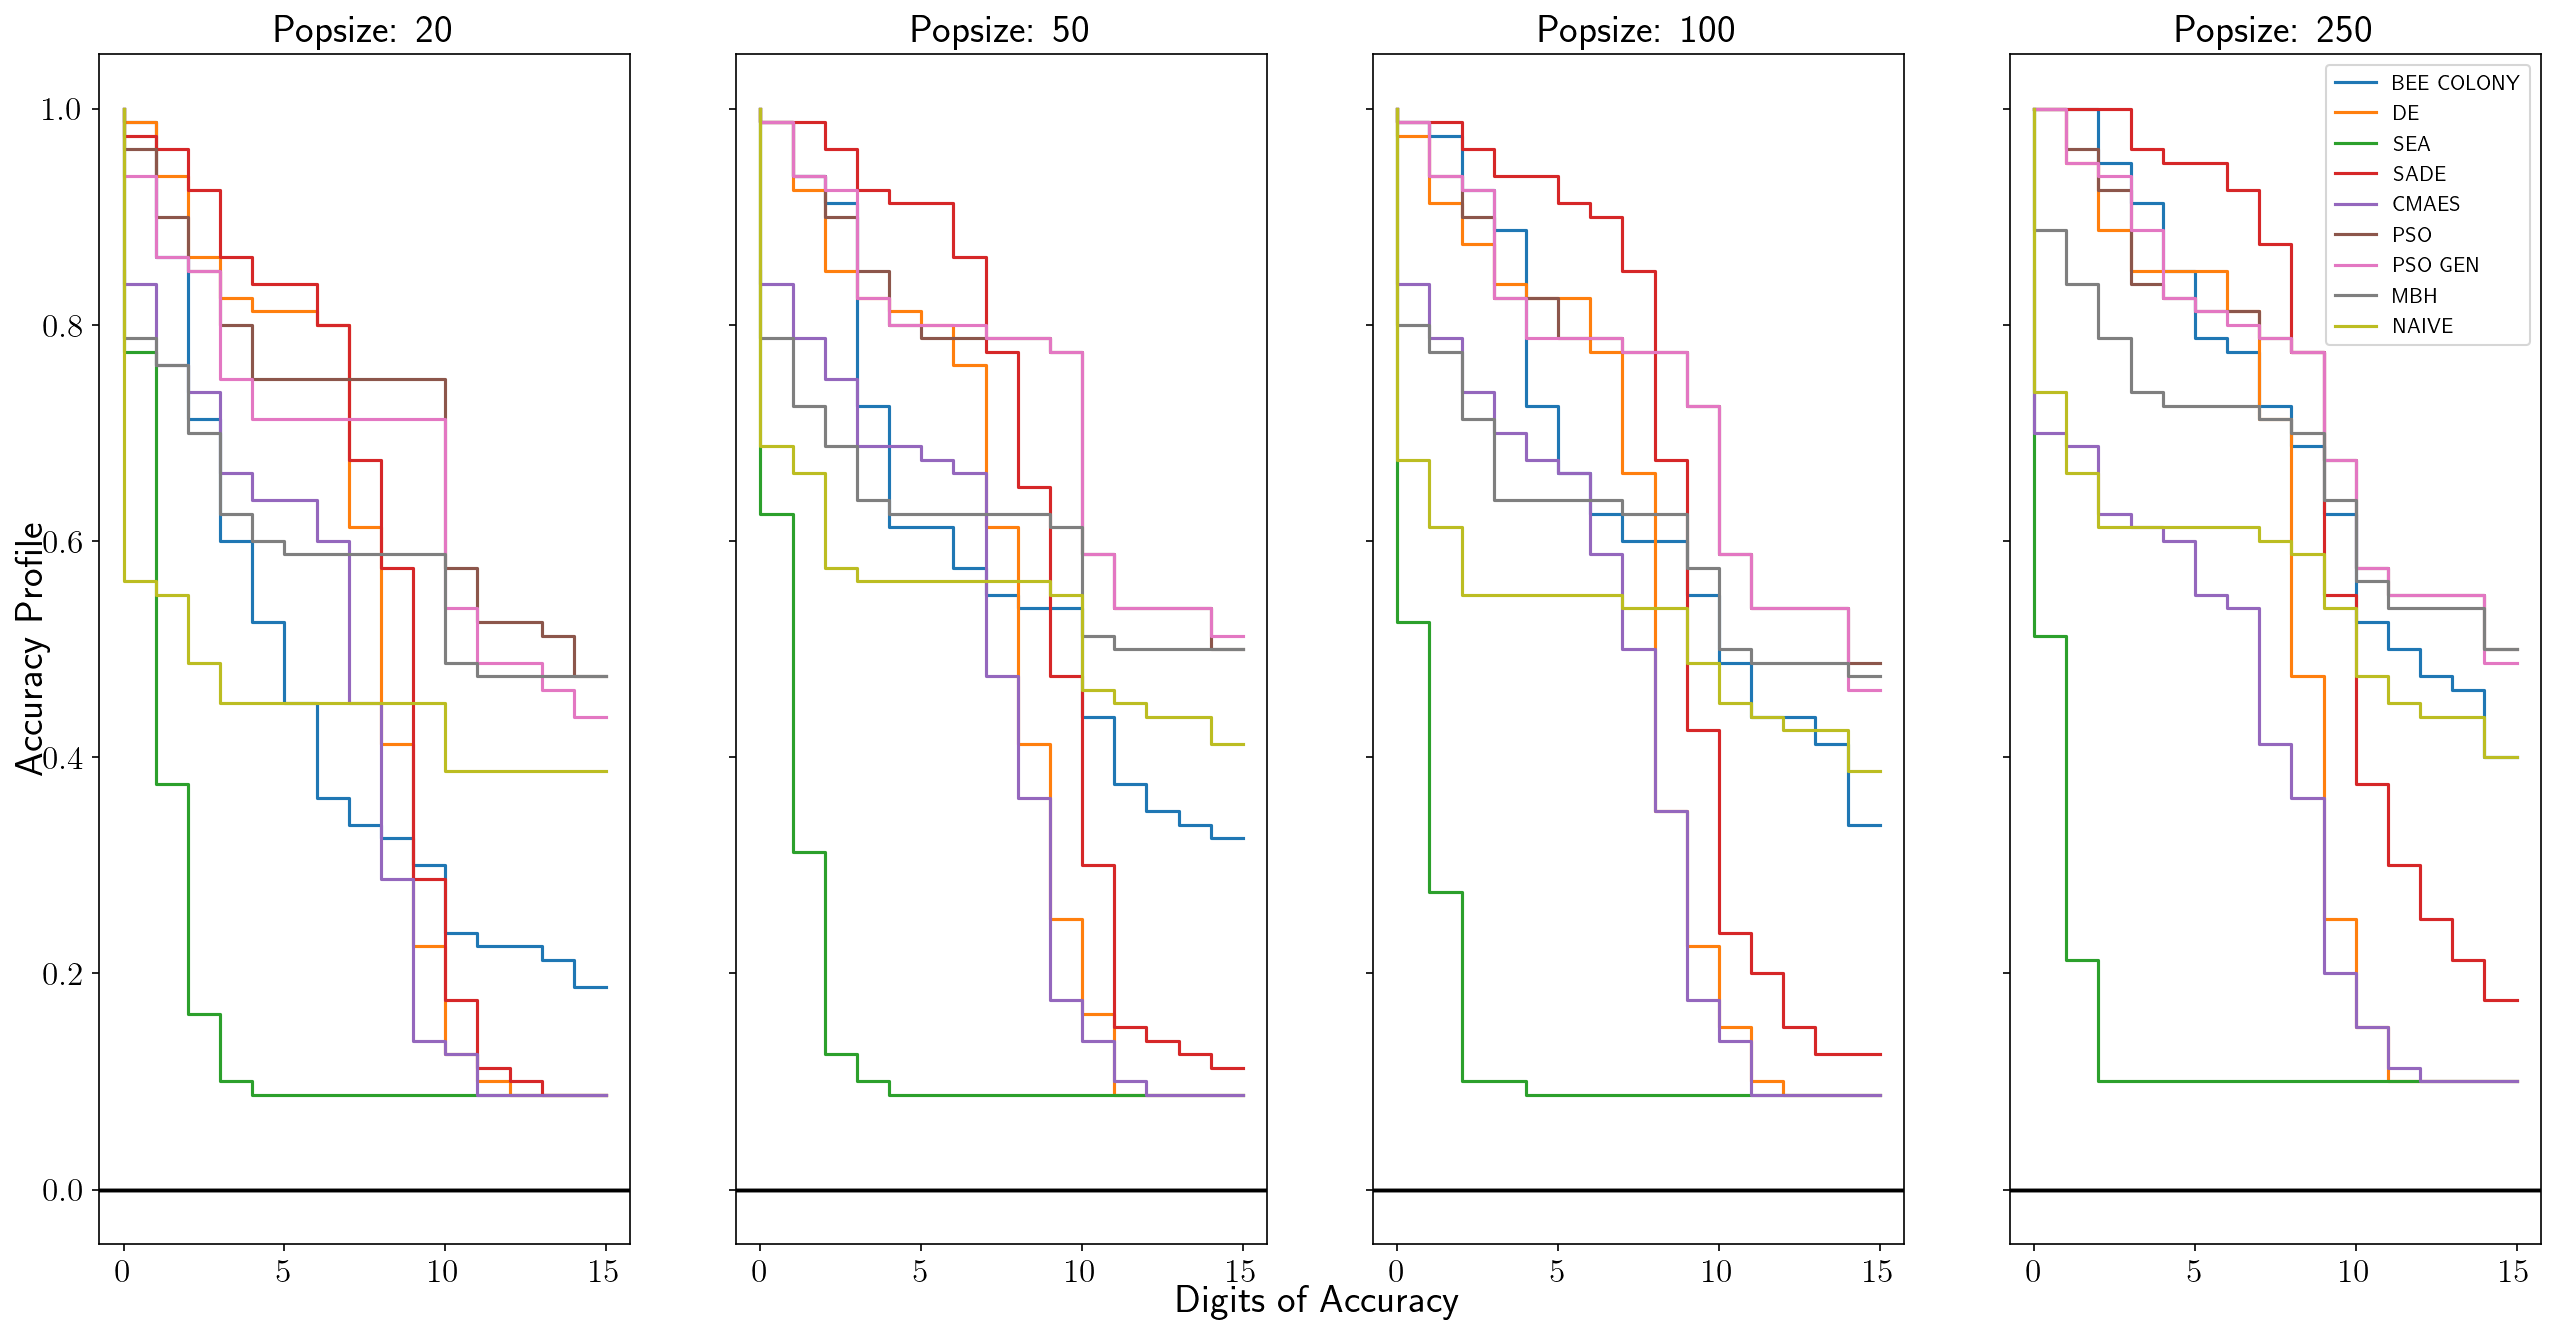

In [13]:
fig_acc_profile_f = bmk_project.accuracy_profile(subplot_kwargs = {"alpha": 0.25})
fig_acc_profile_f.savefig("../Plots/Accuracy_Profiles/Accuracy_Profile_f_Final.png", dpi = 200)

Values for convergence in x value are generally lower. The pattern is still similar to the one from the previous plot. *PSO* and *PSO GEN* keep a high level of accuracy throughout, while algorithms like *SADE*, *DE* and *CMAES* share decreases rapidly after a certain level of digits of accuracy. 

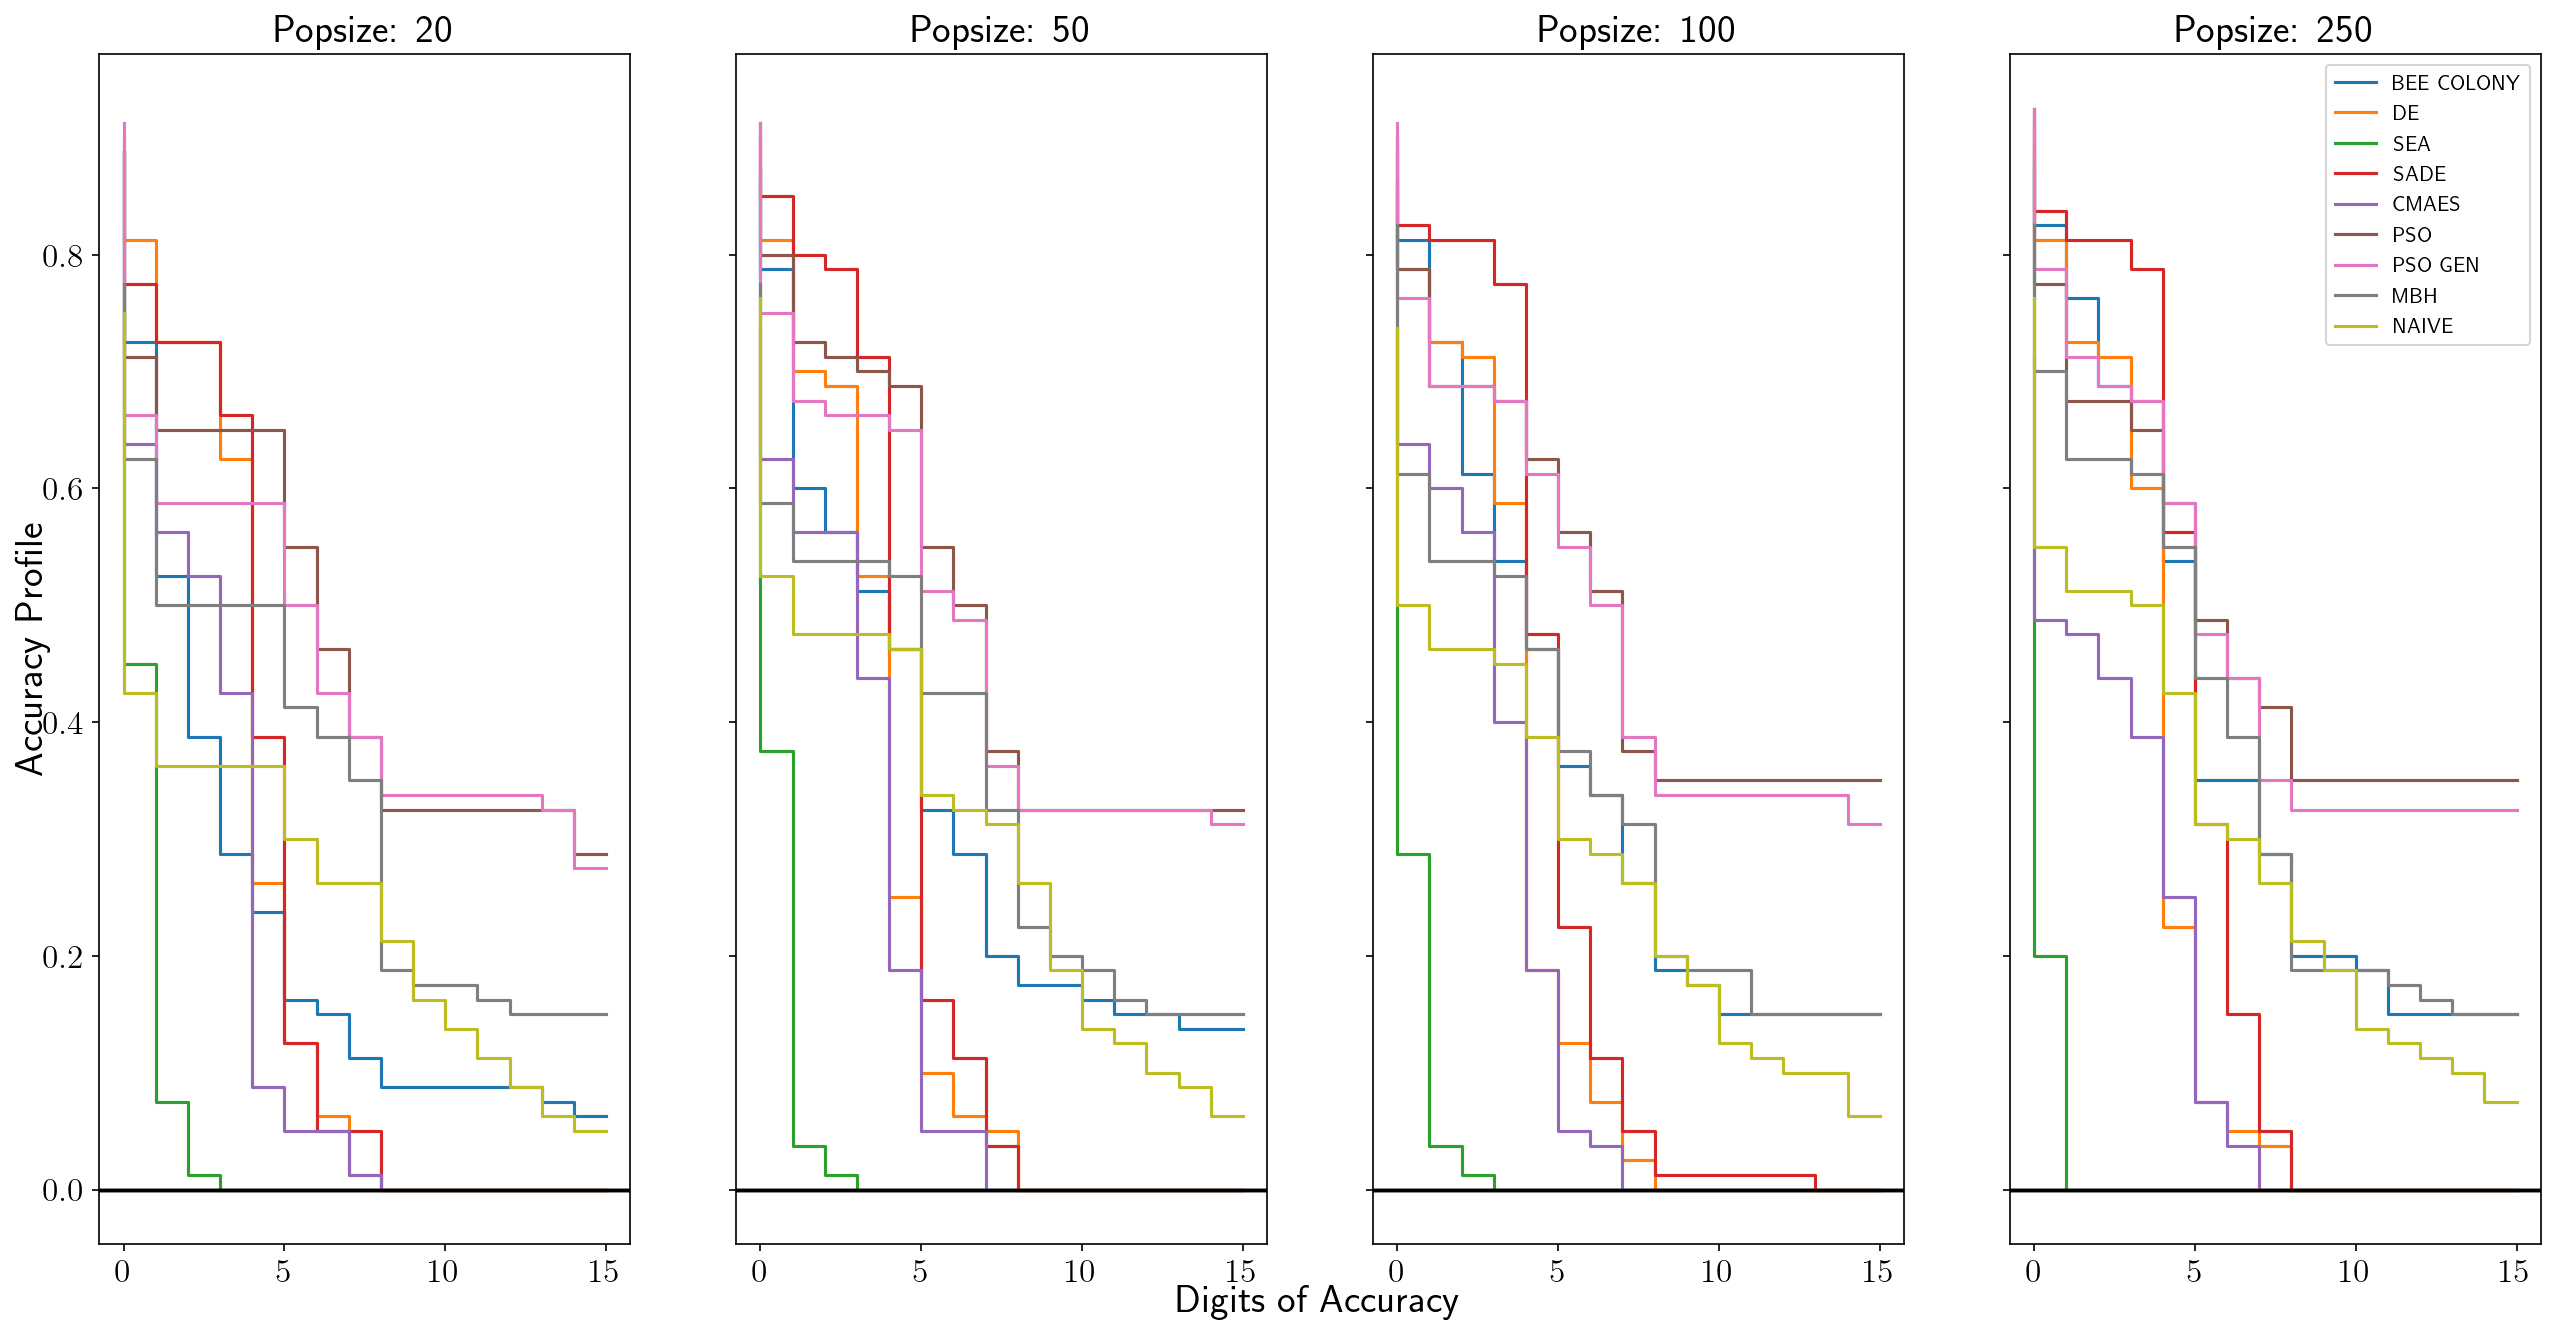

In [14]:
fig_acc_profile_x = bmk_project.accuracy_profile(
    profile_type = "x_value", 
    subplot_kwargs = {"alpha": 0.25}
)
fig_acc_profile_x.savefig("../Plots/Accuracy_Profiles/Accuracy_Profile_x_Final.png", dpi = 200)

In general quality is pretty high for most algortihms. Indicating that they manage to place in the vicinity of the optimal solution most of the time. In general there is no noticeable effect of population size on quality.

Interestingly we found that although *PSO* and *PSO GEN* are inefficient they achieve a very high level of quality. Showing that reliability doesn't imply quality as it appears for *SADE*.

#### Data Profile <a class = "anchor" id = "res_data_profile"></a>

The plot below shows a data profile considering convergence in function value. Note, that the x axis is not relative as for performance profiles but shows the actual number of function evauluations. This allows to compare algorithms between differing population sizes. 

We can see that *SADE* outperforms the other algorithms and has a high probability of convergence $ > 70 \% $. With growing population size this value even exceeds $ 80 \% $. Following closely is *DE* which implies that the self-adaptive part of *SADE* leads to an improvement in reliability. *PSO* and *PSO GEN* are coming in next. Showing high level $ > 60 \% $ once they have enough computational power. Since the algorithms are very similar their lines overlap in some cases. *ABC* surprisingly profits remarkably from growing population size. It even surpasses *PSO* and *PSO GEN* for $ ps = 250 $. Not visible in the plot is *SEA* which didn't converge once and can't be seen as a competitor in this benchmarking exercise. 

The naive approach is the second to lowest performing optimizer. However, it does so within a very short number of function evaluations. As we already noticed from the [performance profiles](#res_perf_profile) and the [competitiveness](#res_competition) section.

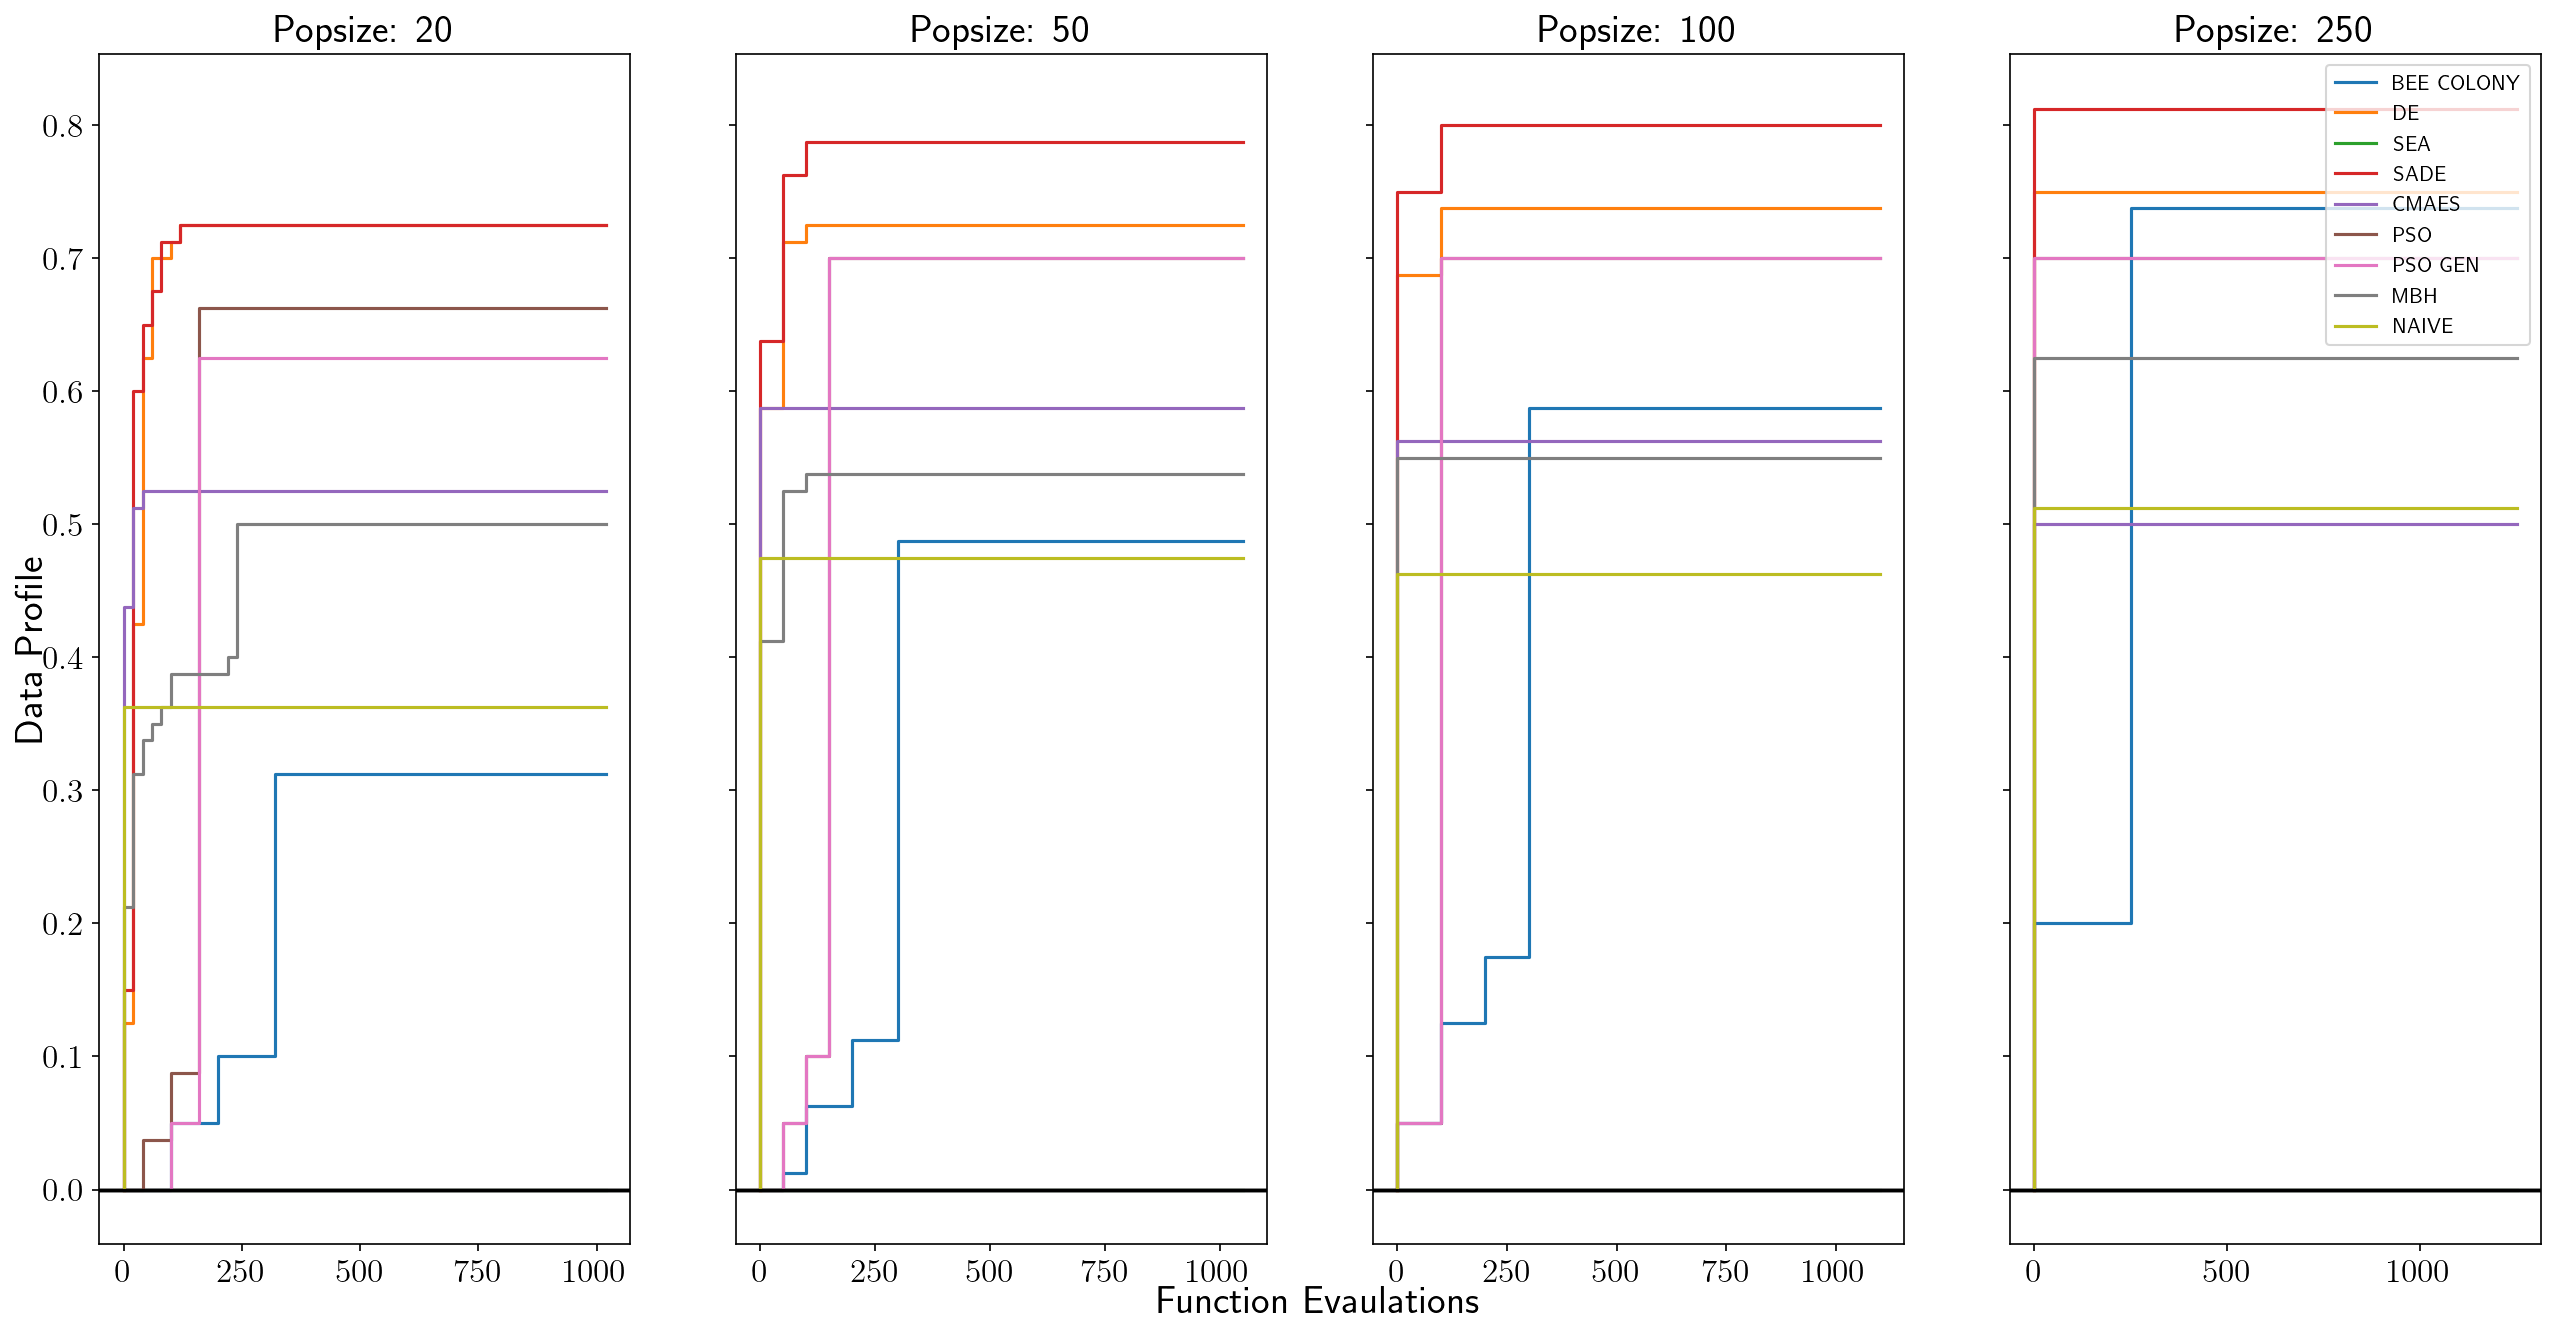

In [15]:
fig_data_profile_f = bmk_project.data_profile(subplot_kwargs = {"alpha": 0.25})
fig_data_profile_f.savefig("../Plots/Data_Profiles/Data_Profile_f_Final.png", dpi = 200)

Interestingly, when considering x value the picture changes in favour of *PSO* and *PSO GEN* for $ ps = 20, 50 $. Besides, the overall picture is similar to function value data profile.

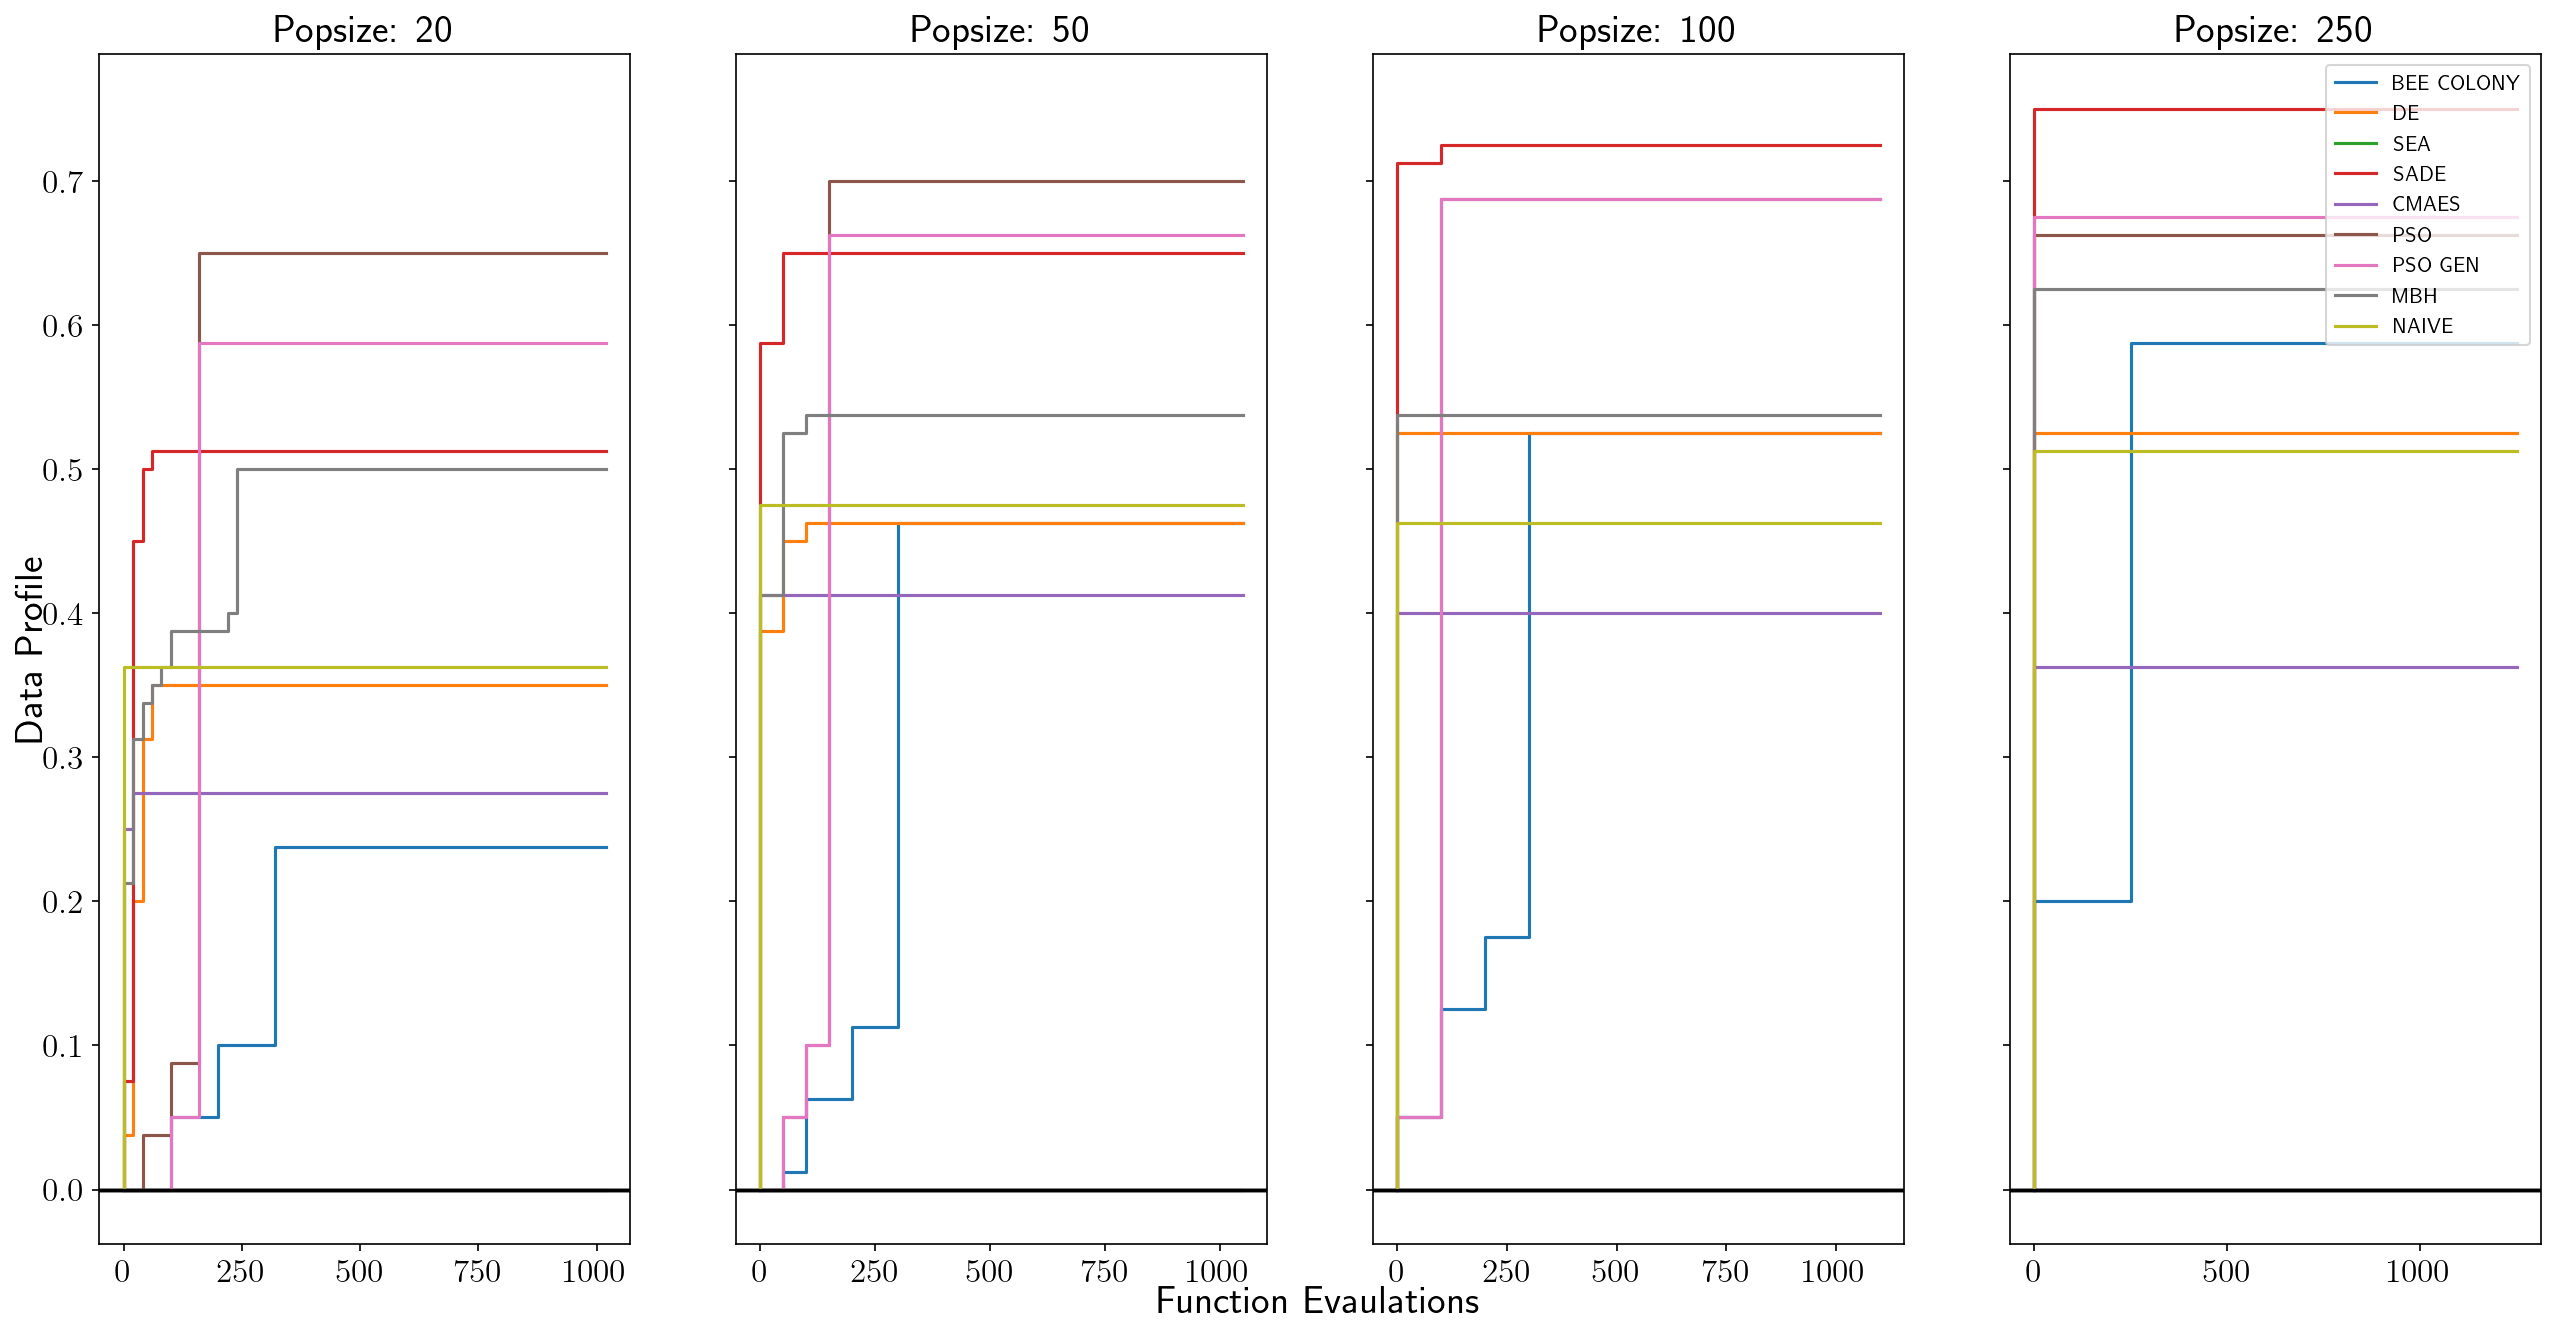

In [16]:
fig_data_profile_x = bmk_project.data_profile(
    profile_type = "x_value", 
    subplot_kwargs = {"alpha": 0.25}
)
fig_data_profile_x.savefig("../Plots/Data_Profiles/Data_Profile_x_Final.png", dpi = 200)

### Conclusion <a class = "anchor" id = "conc"></a>

Concluding from the graphical analysis I judge the considered algorithms with respect to efficency, reliability and quality. To keep it short I will only consider algorithms that achieved good performance in at least one of the aforementioned traits.

*SADE* and *DE* showed very high levels of performance but were also only moderately efficient and gave only low quality results. Making them a poor choice for tasks, where high precision of the solution is desired.

*PSO* and *PSO GEN* showed to be both reliable and accurate although the computational costs were high. Making them a good choice for exercises where computational cost is circumstantial.

*ABC* showed only mediocre performance when considering efficency and quality. However, for a large population base reliability was good and computational cost was acceptable.

Surprisingly the naive approach proved to be a though competitior especially when considering efficency. However, it was also visible thaat given enoguh evaluations global optimizers like *SADE* or *PSO* are able to achieve more reliable results. Also, quality of the solution was not comparable to that achieved by other optimizers. An increase in population size showed a positive effect on reliability. It might be advisable to start with more points since the computational cost rises only marginally.

Concluding there is no one fits all algorithm. The choice of optimizer should be based on the computational budget and the desired accuracy and reliability.

My project suffered from some shortcomings which need to be resolved if a more sound conclusion is desired. First, parameter tuning can dramatically change the performance of an optimizer and second, more iterations for a given algorithm and problem would increase the reliability of this benchmark. Also, a bigger set of test functions should be considered. Further, constrained optimization is of interest with a focus on the type of constraints linear or non-linear. Since population size seems to be affecting the reliability of some optimizers further research in that direction would be useful.

### References <a class = "anchor" id = "ref"></a>

Ackley, David, "A Connectionist Machine for Genetic Hill-Climbing", Kluwer, 1987. <a class = "anchor" id = "Ackley1987"></a>

Beiranvand, Vahid, Hare, Warren and Lucet, Yves, "Best Practices for Comparing Optimization Algorithms", *Optimization and Engineering*, Vol. 18, pp. 815-848, 2017. <a class = "anchor" id = "Beiranvand2017"></a>

Billups, Stephen C., Dirkse, Steven P. and Ferris, Michael C., "A Comparison of Large Scale Mixed Complementarity Problem Solvers", *Computational Optimization and Applications*, Vol. 7, pp. 3-25, 1997. <a class = "anchor" id = "Billups1997"></a>

Biscani, Francesco and Izzo, Dario, "A Parallel Global Multiobjective Framework for Optimization: Pagmo", *Journal of Open Source Software*, Vol. 5, No. 53, p. 2338, 2020. <a class = "anchor" id = "Biscani2020"></a>

Elsayed, Saber M., Sarker, Ruhul A. and Essam, Daryl L., "Differential Evolution with Multiple Strategies for Solving CEC2011 Real-World Numerical Optimization Problems", *2011 IEEE Congress of Evolutionary Computation (CEC)*, pp. 1041-1048, 2011. <a class = "anchor" id = "Elsayed2011"></a>

Hansen, Nikolaus, "The CMA Evolution Strategy: A Comparing Review", Towards a new Evolutionary Computation, Springer Berlin Heidelberg, pp. 75-102, 2006.<a class = "anchor" id = "Hansen2006"></a>

Jamil, Momin and Yang, Xin-She, "A Literature Survey of Benchmark Functions for Global Optimization Problems", *Int. Journal of Mathematical Modelling and Numerical Optimisation*, Vol. 4, No.2, pp. 150-194, 2013. <a class = "anchor" id = "Jamil2013"></a>

Judd, Kenneth L., "Numerical Methods in Economics", *The MIT Press*, Vol. 1, 1998. <a class = "anchor" id = "Judd1998"></a>

Karaboga, Dervis and Basturk, Bahriye, "A Powerful and Efficient Algorithm for Numerical Function Optimization: Artificial Bee Colony (ABC) Algorithm", *Journal of Global Optimization*, Vol. 39, pp. 459-471, 2007<a class = "anchor" id = "Karaboga2007"></a>

Oliveto, Pietro S., He, Jun and Yao, Xin, "Time Complexity of Evolutionary Algorithms for Combinatorial Optimization: A Decade of Results", *International Journal of Automation and Computing*, Vol. 4, pp. 281-293, 2007,. <a class = "anchor" id = "Oliveto2007"></a>

Poli, Riccardo, Kennedy, James and Blackwell, Tim, "Particle Swarm Optimization", *Swarm Intelligence*, Vol. 1, pp. 33-57, 2007. <a class = "anchor" id = "Poli2007"></a>

Rosenbrock, Howard H., "An Automatic Method for Finding the Greatest or Least Value of a Function", *The Computer Journal*, Vol. 3, No. 3, pp. 175-184, 1960. <a class = "anchor" id = "Rosenbrock1960"></a>

Storn, Rainer and Price, Kenneth, "Differential Evoluation - A Simple and Efficient Heuristic for Global Optimization over Continuous Spaces", *Journal of Global Optimization*, Vol. 11, pp. 341-359, 1997. <a class = "anchor" id = "Storn1997"></a>

Tuy, Hoang, "Convex Analysis and Global Optimization", *Springer, Cham*, Springer Optimization and Its Applications, 2016. <a class = "anchor" id = "Hoang2016"></a>

Wales, David J. and Doye, Jonathan P. K., "Global Optimization by Basin-Hopping and the Lowest EnergyStructures ofLennard-Jones Clusters Containing up to 110 Atoms", *The Journal of Physical Chemistry A*, Vol. 101, No. 28, 1997. <a class = "anchor" id = "Wales1997"></a>

### Appendix <a class = "anchor" id = "appendix"></a>

The appendix includes the full table of descriptive statistics as calculated by the `benchmark` method `get_descriptives`. The table lists accuracy metrics as described in the [metrics](#metrics) section grouped by population size and problem for every algorithm.

In [22]:
display(
    HTML(
        bmk_project.descriptive.to_html()
    )
)